In [18]:
"""
Motor Repair Cost Predictor — Production-Ready Data Cleaning Pipeline

This module provides:
- schema validation + type casting
- duplicate checks
- missingness profiling
- domain sanity checks
- outlier flagging (IQR + optional Z-score)
- text readiness profiling
- a modular "pipeline runner"
- a configurable "filter" step to remove records based on chosen rules

Designed for interview code walkthroughs:
- clear separation of concerns
- explicit configs
- non-destructive by default (adds flags/metadata columns)
"""

'\nMotor Repair Cost Predictor — Production-Ready Data Cleaning Pipeline\n\nThis module provides:\n- schema validation + type casting\n- duplicate checks\n- missingness profiling\n- domain sanity checks\n- outlier flagging (IQR + optional Z-score)\n- text readiness profiling\n- a modular "pipeline runner"\n- a configurable "filter" step to remove records based on chosen rules\n\nDesigned for interview code walkthroughs:\n- clear separation of concerns\n- explicit configs\n- non-destructive by default (adds flags/metadata columns)\n'

In [78]:
%pip install scikit-learn

173743.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 7.0 MB/s  0:00:01 eta 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 7.1 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


In [42]:
%pip install matplotlib seaborn

41982.24s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 11.7 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 11.2 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 13.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [seaborn]m6/8 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [ ]:


from __future__ import annotations

from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple, Iterable, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# -------------------------
# Config
# -------------------------
@dataclass(frozen=True)
class CleaningConfig:
    # Parsing / typing
    date_columns: Tuple[str, ...] = ("Claim_Date",)
    dayfirst_dates: bool = True

    numeric_columns: Tuple[str, ...] = (
        "Year_of_Manufacture",
        "Vehicle_Age",
        "Odometer_km",
        "Labour_Hours",
        "Parts_Cost",
        "Paint_Cost",
        "Shop_Rate_per_Hour",
        "Total_Repair_Cost",
        "Initial_Estimate",
        "Settlement_Time_Days",
    )

    # Duplicate rules
    id_column: str = "Claim_ID"

    # Domain checks (adjust if your business rules differ)
    year_min: int = 1980
    year_max: int = 2026
    vehicle_age_min: int = 0
    vehicle_age_max: int = 60
    odometer_min: int = 0
    odometer_max: int = 1_000_000

    # Outlier detection
    iqr_k: float = 1.5
    outlier_columns: Tuple[str, ...] = (
        "Total_Repair_Cost",
        "Parts_Cost",
        "Labour_Hours",
        "Shop_Rate_per_Hour",
        "Paint_Cost",
    )

    # Consistency checks tolerance
    # Example: allow total to be 5% lower than components (discounts, rounding, etc.)
    component_total_tolerance_ratio: float = 0.95

    # Columns used in component consistency logic
    parts_col: str = "Parts_Cost"
    paint_col: str = "Paint_Cost"
    labour_col: str = "Labour_Hours"
    rate_col: str = "Shop_Rate_per_Hour"
    total_col: str = "Total_Repair_Cost"

    # Text fields
    text_columns: Tuple[str, ...] = ("FNOL_Notes", "Repair_Shop_Report")

    # ✅ Low-cost sanity thresholds (NEW)
    parts_min_abs: float = 20.0
    paint_min_abs: float = 30.0
    low_cost_rel_min_ratio: float = 0.01           # 1% of total
    low_cost_high_total_threshold: float = 1500.0  # only “nonsensical” if claim is big




Matplotlib is building the font cache; this may take a moment.


In [20]:
# -------------------------
# Utility / helpers
# -------------------------
def _safe_has_cols(df: pd.DataFrame, cols: Iterable[str]) -> bool:
    return all(c in df.columns for c in cols)

def _iqr_bounds(series: pd.Series, k: float = 1.5) -> Tuple[float, float]:
    s = series.dropna()
    if s.empty:
        return (np.nan, np.nan)
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    return float(q1 - k * iqr), float(q3 + k * iqr)

def _coerce_numeric(df: pd.DataFrame, cols: Iterable[str]) -> pd.DataFrame:
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def _parse_dates(df: pd.DataFrame, cols: Iterable[str], dayfirst: bool = True) -> pd.DataFrame:
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", dayfirst=dayfirst)
    return df



In [21]:
# -------------------------
# Profiling / reporting
# -------------------------
def profile_missingness(df: pd.DataFrame) -> pd.DataFrame:
    """Return a missingness profile (count + pct) per column."""
    miss_cnt = df.isna().sum()
    miss_pct = (miss_cnt / len(df)).replace([np.inf, np.nan], 0.0)
    prof = (
        pd.DataFrame({"missing_count": miss_cnt, "missing_pct": miss_pct})
        .sort_values(["missing_count", "missing_pct"], ascending=False)
    )
    return prof

def profile_cardinality(df: pd.DataFrame, cols: Optional[Iterable[str]] = None) -> pd.DataFrame:
    """Return unique counts for selected cols (or all object cols if not provided)."""
    if cols is None:
        cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    rows = []
    for c in cols:
        if c in df.columns:
            rows.append({"column": c, "n_unique": int(df[c].nunique(dropna=True))})
    return pd.DataFrame(rows).sort_values("n_unique", ascending=False)

def profile_text_fields(df: pd.DataFrame, text_cols: Iterable[str]) -> pd.DataFrame:
    """Return null counts and average length for text fields."""
    rows = []
    for c in text_cols:
        if c in df.columns:
            nulls = int(df[c].isna().sum())
            avg_len = float(df[c].fillna("").astype(str).str.len().mean())
            rows.append({"column": c, "nulls": nulls, "avg_len": avg_len})
    return pd.DataFrame(rows)

In [22]:

# -------------------------
# Cleaning steps (non-destructive: add columns)
# -------------------------
def add_duplicate_flags(df: pd.DataFrame, id_column: str) -> pd.DataFrame:
    """
    Adds:
      - is_duplicate_row: fully duplicated row
      - is_duplicate_id: duplicated Claim_ID (or chosen id column)
    """
    df = df.copy()
    df["is_duplicate_row"] = df.duplicated(keep="first")
    if id_column in df.columns:
        df["is_duplicate_id"] = df[id_column].duplicated(keep="first")
    else:
        df["is_duplicate_id"] = False
    return df

def add_domain_validity_flags(df: pd.DataFrame, cfg: CleaningConfig) -> pd.DataFrame:
    """
    Adds domain sanity flags like:
      - invalid_negative_costs
      - invalid_nonpositive_hours_or_rate
      - invalid_vehicle_year
      - invalid_vehicle_age
      - invalid_odometer
    """
    df = df.copy()

    # Costs non-negative
    cost_cols = [c for c in [cfg.parts_col, cfg.paint_col, cfg.total_col, "Initial_Estimate"] if c in df.columns]
    neg_cost = np.zeros(len(df), dtype=bool)
    for c in cost_cols:
        neg_cost |= (df[c] < 0)
    df["invalid_negative_costs"] = neg_cost

    # Hours / rate > 0
    nonpos = np.zeros(len(df), dtype=bool)
    for c in [cfg.labour_col, cfg.rate_col]:
        if c in df.columns:
            nonpos |= (df[c] <= 0)
    df["invalid_nonpositive_hours_or_rate"] = nonpos

    # Year / age / odometer ranges
    if "Year_of_Manufacture" in df.columns:
        df["invalid_vehicle_year"] = (df["Year_of_Manufacture"] < cfg.year_min) | (df["Year_of_Manufacture"] > cfg.year_max)
    else:
        df["invalid_vehicle_year"] = False

    if "Vehicle_Age" in df.columns:
        df["invalid_vehicle_age"] = (df["Vehicle_Age"] < cfg.vehicle_age_min) | (df["Vehicle_Age"] > cfg.vehicle_age_max)
    else:
        df["invalid_vehicle_age"] = False

    if "Odometer_km" in df.columns:
        df["invalid_odometer"] = (df["Odometer_km"] < cfg.odometer_min) | (df["Odometer_km"] > cfg.odometer_max)
    else:
        df["invalid_odometer"] = False

    # Aggregate
    df["invalid_any_domain"] = (
        df["invalid_negative_costs"]
        | df["invalid_nonpositive_hours_or_rate"]
        | df["invalid_vehicle_year"]
        | df["invalid_vehicle_age"]
        | df["invalid_odometer"]
    )
    return df

def add_cost_consistency_flags(df: pd.DataFrame, cfg: CleaningConfig) -> pd.DataFrame:
    """
    Adds:
      - invalid_total_lt_parts_paint
      - suspicious_total_lt_components  (Total < tolerance * (Parts + Paint + Labour*Rate))
    """
    df = df.copy()

    # Total >= Parts + Paint
    if _safe_has_cols(df, [cfg.total_col, cfg.parts_col, cfg.paint_col]):
        parts_paint = df[cfg.parts_col].fillna(0) + df[cfg.paint_col].fillna(0)
        df["invalid_total_lt_parts_paint"] = df[cfg.total_col] < parts_paint
    else:
        df["invalid_total_lt_parts_paint"] = False

    # Total >= tolerance*(Parts + Paint + Labour*Rate)
    if _safe_has_cols(df, [cfg.total_col, cfg.parts_col, cfg.paint_col, cfg.labour_col, cfg.rate_col]):
        comp_total = (
            df[cfg.parts_col].fillna(0)
            + df[cfg.paint_col].fillna(0)
            + df[cfg.labour_col].fillna(0) * df[cfg.rate_col].fillna(0)
        )
        df["suspicious_total_lt_components"] = (df[cfg.total_col] + 1e-6) < (cfg.component_total_tolerance_ratio * comp_total)
    else:
        df["suspicious_total_lt_components"] = False

    df["invalid_any_cost_consistency"] = df["invalid_total_lt_parts_paint"] | df["suspicious_total_lt_components"]
    return df

def add_outlier_flags_iqr(df: pd.DataFrame, columns: Iterable[str], k: float = 1.5) -> pd.DataFrame:
    """
    Adds per-column IQR outlier flags, plus:
      - any_outlier_iqr
    """
    df = df.copy()
    flags = []
    for c in columns:
        if c not in df.columns:
            continue
        lo, hi = _iqr_bounds(df[c], k=k)
        col_flag = f"outlier_iqr__{c}"
        df[col_flag] = (df[c] < lo) | (df[c] > hi)
        flags.append(col_flag)

    if flags:
        df["any_outlier_iqr"] = df[flags].any(axis=1)
    else:
        df["any_outlier_iqr"] = False
    return df

def add_text_quality_features(df: pd.DataFrame, text_cols: Iterable[str]) -> pd.DataFrame:
    """
    Adds simple text readiness features:
      - text_len__<col>
      - text_is_missing__<col>
    """
    df = df.copy()
    for c in text_cols:
        if c not in df.columns:
            continue
        s = df[c].astype("string")
        df[f"text_is_missing__{c}"] = s.isna()
        df[f"text_len__{c}"] = s.fillna("").str.len().astype(int)
    return df




In [23]:
# -------------------------
# Filtering step (configurable)
# -------------------------
def filter_rows(
    df: pd.DataFrame,
    *,
    drop_if_true: Optional[List[str]] = None,
    drop_duplicates: bool = False,
    drop_duplicate_id: bool = False,
) -> pd.DataFrame:
    """
    Returns a filtered dataframe based on boolean flag columns.
    This is intentionally separated from flag-creation.
    
    Parameters
    ----------
    drop_if_true:
        List of boolean columns; if any are True, row is dropped.
        Example: ["invalid_any_domain", "invalid_any_cost_consistency", "is_duplicate_row"]
    drop_duplicates:
        If True, drop fully duplicated rows using pandas drop_duplicates()
    drop_duplicate_id:
        If True, drop rows where is_duplicate_id == True (keeps first)
    """
    out = df.copy()

    if drop_duplicates:
        out = out.drop_duplicates()

    if drop_duplicate_id and "is_duplicate_id" in out.columns:
        out = out.loc[~out["is_duplicate_id"]].copy()

    if drop_if_true:
        missing_cols = [c for c in drop_if_true if c not in out.columns]
        if missing_cols:
            raise ValueError(f"filter_rows: missing flag columns: {missing_cols}")

        mask_drop = np.zeros(len(out), dtype=bool)
        for c in drop_if_true:
            mask_drop |= out[c].fillna(False).astype(bool).to_numpy()

        out = out.loc[~mask_drop].copy()

    return out




In [29]:
# -------------------------
# Low-cost sanity flags
# -------------------------
def add_low_cost_sanity_flags(df: pd.DataFrame, cfg: CleaningConfig) -> pd.DataFrame:
    """
    Flags suspiciously low Parts_Cost / Paint_Cost using:
      - absolute floors (parts_min_abs, paint_min_abs)
      - relative ratio to Total_Repair_Cost (low_cost_rel_min_ratio)
      - severity-conditioned rule (only problematic when Total exceeds low_cost_high_total_threshold)

    Adds:
      - low_parts_abs, low_paint_abs
      - low_parts_rel, low_paint_rel
      - low_parts_high_total, low_paint_high_total
      - suspicious_low_cost
    """
    df = df.copy()

    required = [cfg.parts_col, cfg.paint_col, cfg.total_col]
    if not _safe_has_cols(df, required):
        # If missing columns, add safe defaults and exit
        df["suspicious_low_cost"] = False
        return df

    total = df[cfg.total_col].replace(0, np.nan)  # avoid divide-by-zero
    parts = df[cfg.parts_col]
    paint = df[cfg.paint_col]

    # Absolute
    df["low_parts_abs"] = parts < cfg.parts_min_abs
    df["low_paint_abs"] = paint < cfg.paint_min_abs

    # Relative (to total)
    df["low_parts_rel"] = (parts / total) < cfg.low_cost_rel_min_ratio
    df["low_paint_rel"] = (paint / total) < cfg.low_cost_rel_min_ratio

    # Conditioned on high severity
    df["low_parts_high_total"] = (df[cfg.total_col] > cfg.low_cost_high_total_threshold) & (parts < cfg.parts_min_abs)
    df["low_paint_high_total"] = (df[cfg.total_col] > cfg.low_cost_high_total_threshold) & (paint < cfg.paint_min_abs)

    df["suspicious_low_cost"] = (
        df["low_parts_high_total"]
        | df["low_paint_high_total"]
        # Optional: also flag extreme relative lows on high totals
        | ((df[cfg.total_col] > cfg.low_cost_high_total_threshold) & df["low_parts_rel"])
        | ((df[cfg.total_col] > cfg.low_cost_high_total_threshold) & df["low_paint_rel"])
    ).fillna(False)

    return df

In [27]:
# -------------------------
# Pipeline runner
# -------------------------
def run_cleaning_pipeline(df: pd.DataFrame, cfg: Optional[CleaningConfig] = None) -> Dict[str, Any]:
    cfg = cfg or CleaningConfig()
    df0 = df.copy()

    # Step 1: types
    df1 = _parse_dates(df0, cfg.date_columns, dayfirst=cfg.dayfirst_dates)
    df1 = _coerce_numeric(df1, cfg.numeric_columns)

    # Step 2: flags/features
    df2 = add_duplicate_flags(df1, cfg.id_column)
    df2 = add_domain_validity_flags(df2, cfg)
    df2 = add_cost_consistency_flags(df2, cfg)
    
    df2 = add_low_cost_sanity_flags(df2, cfg)

    df2 = add_outlier_flags_iqr(df2, cfg.outlier_columns, k=cfg.iqr_k)
    df2 = add_text_quality_features(df2, cfg.text_columns)

    # Optional quick reports (keep lightweight for interviews)
    reports = {
        "missingness": df2.isna().sum().sort_values(ascending=False),
        "flag_counts": df2.filter(regex="^(invalid_|suspicious_|is_duplicate|any_outlier)").sum().sort_values(ascending=False),
    }

    return {"df_enriched": df2, "reports": reports}

In [32]:
# -------------------------
# Example pipeline usage (Jupyter-friendly)
# -------------------------
df_raw = pd.read_csv("motor_repair_costs.csv")

cfg = CleaningConfig(
    # tweak thresholds if needed
    parts_min_abs=20.0,
    paint_min_abs=30.0,
    low_cost_high_total_threshold=1500.0,
    low_cost_rel_min_ratio=0.01
)

result = run_cleaning_pipeline(df_raw, cfg=cfg)
df_enriched = result["df_enriched"]
reports = result["reports"]

print("Raw shape:", df_raw.shape)
print("Enriched shape:", df_enriched.shape)
print("\nTop flag counts:")
print(reports["flag_counts"].head(15))

# ✅ Filter example: remove only hard-invalid rows + duplicates
df_filtered_hard = filter_rows(
    df_enriched,
    drop_if_true=[
        "invalid_any_domain",
        "invalid_any_cost_consistency",
        "is_duplicate_row",
        "is_duplicate_id",
    ],
)

# ✅ Filter example: also remove suspicious low-cost rows (if you want a 'strict' dataset)
df_filtered_strict = filter_rows(
    df_enriched,
    drop_if_true=[
        "invalid_any_domain",
        "invalid_any_cost_consistency",
        "is_duplicate_row",
        "is_duplicate_id",
        "suspicious_low_cost",      # <-- NEW filter option
    ],
)

print("\nFiltered (hard) shape:", df_filtered_hard.shape)
print("Filtered (strict) shape:", df_filtered_strict.shape)

# Quick sanity: how many are flagged as suspicious low cost?
print("\nSuspicious low-cost rate:", df_enriched["suspicious_low_cost"].mean())
print("\nSample suspicious low-cost rows:")
display(
    df_enriched.loc[df_enriched["suspicious_low_cost"]].head(10)[
        ["Claim_ID", "Total_Repair_Cost", "Parts_Cost", "Paint_Cost", "Labour_Hours", "Shop_Rate_per_Hour",
         "low_parts_abs", "low_paint_abs", "low_parts_high_total", "low_paint_high_total"]
    ]
)

Raw shape: (50000, 21)
Enriched shape: (50000, 49)

Top flag counts:
any_outlier_iqr                      615
suspicious_low_cost                  607
invalid_nonpositive_hours_or_rate     41
invalid_any_domain                    41
invalid_total_lt_parts_paint           3
invalid_any_cost_consistency           3
is_duplicate_row                       0
is_duplicate_id                        0
invalid_negative_costs                 0
invalid_vehicle_year                   0
invalid_vehicle_age                    0
invalid_odometer                       0
suspicious_total_lt_components         0
dtype: int64

Filtered (hard) shape: (49959, 49)
Filtered (strict) shape: (49352, 49)

Suspicious low-cost rate: 0.01214

Sample suspicious low-cost rows:


,Claim_ID,Total_Repair_Cost,Parts_Cost,Paint_Cost,Labour_Hours,Shop_Rate_per_Hour,low_parts_abs,low_paint_abs,low_parts_high_total,low_paint_high_total
15,CLM000016,2643.03,1891.76,3.11,6.1,122.65,False,True,False,True
192,CLM000193,2048.64,1668.96,8.81,5.4,68.68,False,True,False,True
348,CLM000349,1934.71,1496.34,11.18,8.1,52.74,False,True,False,True
385,CLM000386,2408.78,1671.46,29.54,6.4,110.59,False,True,False,True
398,CLM000399,2454.20,2328.96,9.74,2.5,46.20,False,True,False,True
454,CLM000455,4409.74,3987.65,26.38,5.1,77.59,False,True,False,True
585,CLM000586,2732.06,2193.80,18.08,8.1,64.22,False,True,False,True
643,CLM000644,1577.71,17.98,689.93,7.4,117.54,True,False,True,False
647,CLM000648,3345.33,2250.60,32.55,8.7,122.09,False,False,False,False
827,CLM000828,2501.90,2111.11,27.59,8.1,44.84,False,True,False,True


In [16]:
df_enriched.columns

Index(['Claim_ID', 'Claim_Date', 'Vehicle_Make', 'Vehicle_Model',
       'Year_of_Manufacture', 'Vehicle_Age', 'Odometer_km', 'Loss_Cause',
       'Repair_Shop_ID', 'Region', 'Labour_Hours', 'Parts_Cost', 'Paint_Cost',
       'Shop_Rate_per_Hour', 'Total_Repair_Cost', 'Shop_Repair_Type',
       'FNOL_Notes', 'Repair_Shop_Report', 'Photos_Available',
       'Initial_Estimate', 'Liability_Assessment', 'is_duplicate_row',
       'is_duplicate_id', 'invalid_negative_costs',
       'invalid_nonpositive_hours_or_rate', 'invalid_vehicle_year',
       'invalid_vehicle_age', 'invalid_odometer', 'invalid_any_domain',
       'invalid_total_lt_parts_paint', 'suspicious_total_lt_components',
       'invalid_any_cost_consistency', 'outlier_iqr__Total_Repair_Cost',
       'outlier_iqr__Parts_Cost', 'outlier_iqr__Labour_Hours',
       'outlier_iqr__Shop_Rate_per_Hour', 'outlier_iqr__Paint_Cost',
       'any_outlier_iqr', 'text_is_missing__FNOL_Notes',
       'text_len__FNOL_Notes', 'text_is_missing__R

In [15]:
df_enriched.head()

,Claim_ID,Claim_Date,Vehicle_Make,Vehicle_Model,Year_of_Manufacture,Vehicle_Age,Odometer_km,Loss_Cause,Repair_Shop_ID,Region,...,outlier_iqr__Total_Repair_Cost,outlier_iqr__Parts_Cost,outlier_iqr__Labour_Hours,outlier_iqr__Shop_Rate_per_Hour,outlier_iqr__Paint_Cost,any_outlier_iqr,text_is_missing__FNOL_Notes,text_len__FNOL_Notes,text_is_missing__Repair_Shop_Report,text_len__Repair_Shop_Report
0,CLM000001,2025-02-16,Kia,Corolla,2011,14,155321,Side Impact,Shop_0062,West,...,False,False,False,False,False,False,False,98,False,87
1,CLM000002,2025-04-06,Hyundai,C-Class,2017,8,116957,Single Vehicle Crash,Shop_0319,North,...,False,False,False,False,False,False,False,94,False,97
2,CLM000003,2024-08-08,Toyota,Altima,2010,15,140811,Head-on Collision,Shop_1699,North,...,False,False,False,False,False,False,False,92,False,117
3,CLM000004,2023-12-07,Toyota,Elantra,2005,20,206379,Rear-end Collision,Shop_0430,Central,...,False,False,False,False,False,False,False,107,False,91
4,CLM000005,2023-12-11,Hyundai,Focus,2007,18,242392,Side Impact,Shop_1590,East,...,False,False,False,False,False,False,False,96,False,80


In [224]:
df_filtered_strict.to_csv(
    "/Users/asanga/suncorp/df_filtered_strict_ext.csv",index=False
)

<b> Exploratory data analysis <b>

In [33]:
def compute_cost_driver_correlations(
    df: pd.DataFrame,
    target: str = "Total_Repair_Cost",
    numeric_features: list[str] | None = None,
) -> pd.DataFrame:
    """
    Computes correlation of numeric features with Total_Repair_Cost
    to identify primary cost drivers.
    """
    if numeric_features is None:
        numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

    corr = (
        df[numeric_features]
        .corr()[target]
        .drop(target)
        .sort_values(ascending=False)
        .reset_index()
        .rename(columns={"index": "feature", target: "correlation"})
    )

    return corr


In [34]:
def compute_cost_composition(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the average contribution of cost components
    to the total repair cost.
    """
    comp = pd.DataFrame({
        "Parts": df["Parts_Cost"] / df["Total_Repair_Cost"],
        "Paint": df["Paint_Cost"] / df["Total_Repair_Cost"],
        "Labour": (df["Labour_Hours"] * df["Shop_Rate_per_Hour"]) / df["Total_Repair_Cost"],
    })

    summary = (
        comp.replace([np.inf, -np.inf], np.nan)
            .dropna()
            .mean()
            .reset_index()
            .rename(columns={"index": "component", 0: "avg_share_of_total"})
    )

    return summary


In [35]:
def cost_by_dimension(
    df: pd.DataFrame,
    dimension: str,
    target: str = "Total_Repair_Cost",
    min_count: int = 100,
) -> pd.DataFrame:
    """
    Aggregates average cost by a categorical dimension
    and filters out small sample noise.
    """
    grouped = (
        df.groupby(dimension)[target]
        .agg(
            avg_cost="mean",
            median_cost="median",
            claim_count="count"
        )
        .reset_index()
    )

    return grouped[grouped["claim_count"] >= min_count].sort_values("avg_cost", ascending=False)


In [36]:
def identify_cost_anomalies(df: pd.DataFrame) -> pd.DataFrame:
    """
    Flags claims that are high cost but structurally inconsistent.
    """
    anomalies = df[
        (df["Total_Repair_Cost"] > df["Total_Repair_Cost"].quantile(0.95)) &
        (
            df["suspicious_low_cost"] |
            df["any_outlier_iqr"] |
            df["invalid_any_cost_consistency"]
        )
    ]

    return anomalies[
        [
            "Claim_ID",
            "Total_Repair_Cost",
            "Parts_Cost",
            "Paint_Cost",
            "Labour_Hours",
            "Shop_Rate_per_Hour",
            "suspicious_low_cost",
            "any_outlier_iqr",
        ]
    ]


In [37]:
# Assume df_enriched is output from run_cleaning_pipeline()

# 1. Cost drivers
cost_drivers = compute_cost_driver_correlations(df_enriched)

# 2. Cost composition
cost_composition = compute_cost_composition(df_enriched)

# 3. Patterns by key dimensions
cost_by_loss = cost_by_dimension(df_enriched, "Loss_Cause")
cost_by_region = cost_by_dimension(df_enriched, "Region")

# 4. Anomalies
cost_anomalies = identify_cost_anomalies(df_enriched)

print("Top cost drivers:")
display(cost_drivers.head(8))

print("\nCost composition:")
display(cost_composition)

print("\nAvg cost by loss cause:")
display(cost_by_loss)

print("\nAvg cost by region:")
display(cost_by_region)

print("\nSample cost anomalies:")
display(cost_anomalies.head(10))


Top cost drivers:


,feature,correlation
0,Parts_Cost,0.921024
1,Initial_Estimate,0.911124
2,Paint_Cost,0.232194
3,Labour_Hours,0.227752
4,Shop_Rate_per_Hour,0.200932
5,Year_of_Manufacture,0.004492
6,text_len__Repair_Shop_Report,0.003067
7,text_len__FNOL_Notes,-0.003937



Cost composition:


,component,avg_share_of_total
0,Parts,0.596537
1,Paint,0.193989
2,Labour,0.209474



Avg cost by loss cause:


,Loss_Cause,avg_cost,median_cost,claim_count
1,Parking Lot Incident,2912.624651,2869.97,8346
4,Single Vehicle Crash,2904.990144,2865.78,8386
0,Head-on Collision,2898.026459,2856.81,8319
5,Weather Damage,2892.969469,2859.61,8498
2,Rear-end Collision,2886.618838,2855.02,8195
3,Side Impact,2881.661116,2849.50,8256



Avg cost by region:


,Region,avg_cost,median_cost,claim_count
2,North,2905.852297,2874.300,12653
4,West,2898.943690,2861.965,7350
0,Central,2894.151754,2856.720,12439
1,East,2893.615948,2852.750,9939
3,South,2884.236395,2846.200,7619



Sample cost anomalies:


,Claim_ID,Total_Repair_Cost,Parts_Cost,Paint_Cost,Labour_Hours,Shop_Rate_per_Hour,suspicious_low_cost,any_outlier_iqr
14,CLM000015,5760.52,5172.30,269.90,8.0,39.79,False,True
132,CLM000133,5937.72,4338.69,630.99,9.3,104.09,False,True
408,CLM000409,4983.91,4515.95,432.57,0.3,117.96,False,True
589,CLM000590,5780.88,4018.78,460.24,11.9,109.40,False,True
1014,CLM001015,6011.59,4394.31,784.38,10.8,77.12,False,True
1196,CLM001197,5914.71,4889.89,570.05,8.6,52.88,False,True
1207,CLM001208,5643.77,4898.30,435.46,6.7,46.27,False,True
1209,CLM001210,5189.97,4503.03,442.33,5.9,41.46,False,True
1217,CLM001218,5439.46,4727.27,251.41,5.4,85.33,False,True
1260,CLM001261,5415.29,3566.05,1196.51,7.5,87.03,False,True


In [38]:

# -----------------------------
# Helper plotting utilities
# -----------------------------
def _ensure_cols(df: pd.DataFrame, cols: list[str]) -> None:
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

def plot_histogram_with_quantiles(
    df: pd.DataFrame,
    col: str,
    bins: int = 50,
    title: str | None = None,
) -> None:
    _ensure_cols(df, [col])
    s = df[col].dropna()

    q50, q90, q95, q99 = s.quantile([0.50, 0.90, 0.95, 0.99])

    plt.figure()
    plt.hist(s, bins=bins)
    plt.axvline(q50)
    plt.axvline(q90)
    plt.axvline(q95)
    plt.axvline(q99)
    plt.title(title or f"Distribution of {col} (with quantiles)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

def plot_top_bars(
    df_agg: pd.DataFrame,
    x_col: str,
    y_col: str,
    top_n: int = 10,
    title: str | None = None,
    xlabel: str | None = None,
    ylabel: str | None = None,
) -> None:
    _ensure_cols(df_agg, [x_col, y_col])
    plot_df = df_agg.sort_values(y_col, ascending=False).head(top_n)

    plt.figure()
    plt.bar(plot_df[x_col].astype(str), plot_df[y_col].astype(float))
    plt.title(title or f"Top {top_n} by {y_col}")
    plt.xlabel(xlabel or x_col)
    plt.ylabel(ylabel or y_col)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def plot_scatter(
    df: pd.DataFrame,
    x: str,
    y: str,
    sample: int = 8000,
    title: str | None = None,
) -> None:
    _ensure_cols(df, [x, y])
    d = df[[x, y]].dropna()
    if len(d) > sample:
        d = d.sample(sample, random_state=42)

    plt.figure()
    plt.scatter(d[x], d[y], s=8)
    plt.title(title or f"{y} vs {x}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.tight_layout()
    plt.show()

def plot_cost_composition_pie(
    df: pd.DataFrame,
    total_col: str = "Total_Repair_Cost",
    parts_col: str = "Parts_Cost",
    paint_col: str = "Paint_Cost",
    labour_hours_col: str = "Labour_Hours",
    rate_col: str = "Shop_Rate_per_Hour",
) -> None:
    _ensure_cols(df, [total_col, parts_col, paint_col, labour_hours_col, rate_col])

    total = df[total_col].replace(0, np.nan)
    parts_share = (df[parts_col] / total).replace([np.inf, -np.inf], np.nan)
    paint_share = (df[paint_col] / total).replace([np.inf, -np.inf], np.nan)
    labour_share = ((df[labour_hours_col] * df[rate_col]) / total).replace([np.inf, -np.inf], np.nan)

    shares = pd.Series({
        "Parts": parts_share.dropna().mean(),
        "Paint": paint_share.dropna().mean(),
        "Labour": labour_share.dropna().mean(),
    }).fillna(0)

    # Normalise (sometimes shares don't sum to 1 due to rounding/other costs)
    shares = shares / shares.sum() if shares.sum() > 0 else shares

    plt.figure()
    plt.pie(shares.values, labels=shares.index, autopct="%1.1f%%")
    plt.title("Average cost composition (share of total)")
    plt.tight_layout()
    plt.show()


# -----------------------------
# Analysis functions (return tables) + plot companions
# -----------------------------
def compute_cost_driver_correlations(
    df: pd.DataFrame,
    target: str = "Total_Repair_Cost",
    numeric_features: list[str] | None = None,
) -> pd.DataFrame:
    if numeric_features is None:
        numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    _ensure_cols(df, [target])

    corr = (
        df[numeric_features]
        .corr()[target]
        .drop(target, errors="ignore")
        .sort_values(ascending=False)
        .reset_index()
        .rename(columns={"index": "feature", target: "correlation"})
    )
    return corr

def plot_cost_driver_correlations(corr_df: pd.DataFrame, top_n: int = 10) -> None:
    _ensure_cols(corr_df, ["feature", "correlation"])
    plot_df = corr_df.head(top_n)

    plt.figure()
    plt.bar(plot_df["feature"], plot_df["correlation"])
    plt.title(f"Top {top_n} correlations with Total_Repair_Cost")
    plt.xlabel("Feature")
    plt.ylabel("Correlation")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def cost_by_dimension(
    df: pd.DataFrame,
    dimension: str,
    target: str = "Total_Repair_Cost",
    min_count: int = 100,
) -> pd.DataFrame:
    _ensure_cols(df, [dimension, target])
    grouped = (
        df.groupby(dimension)[target]
        .agg(avg_cost="mean", median_cost="median", claim_count="count")
        .reset_index()
    )
    grouped = grouped[grouped["claim_count"] >= min_count].sort_values("avg_cost", ascending=False)
    return grouped

def identify_cost_anomalies(
    df: pd.DataFrame,
    target: str = "Total_Repair_Cost",
    high_quantile: float = 0.95,
    anomaly_flags: list[str] | None = None,
) -> pd.DataFrame:
    if anomaly_flags is None:
        anomaly_flags = ["suspicious_low_cost", "any_outlier_iqr", "invalid_any_cost_consistency"]

    _ensure_cols(df, [target])
    for f in anomaly_flags:
        if f not in df.columns:
            # if a flag doesn't exist, treat as False
            df = df.copy()
            df[f] = False

    threshold = df[target].quantile(high_quantile)
    mask = df[target] > threshold
    for f in anomaly_flags:
        mask &= df[f].fillna(False)

    anomalies = df.loc[mask].copy()
    cols = ["Claim_ID", target, "Parts_Cost", "Paint_Cost", "Labour_Hours", "Shop_Rate_per_Hour"] + anomaly_flags
    cols = [c for c in cols if c in anomalies.columns]
    return anomalies[cols].sort_values(target, ascending=False)

def plot_anomaly_rate_by_dimension(
    df: pd.DataFrame,
    dimension: str,
    anomaly_flag: str = "suspicious_low_cost",
    min_count: int = 100,
) -> pd.DataFrame:
    """
    Plots anomaly rate by a dimension (e.g., by region or repair shop).
    Returns the table used for plotting.
    """
    _ensure_cols(df, [dimension])
    if anomaly_flag not in df.columns:
        raise ValueError(f"Missing anomaly flag column: {anomaly_flag}")

    agg = (
        df.groupby(dimension)
        .agg(
            claim_count=(anomaly_flag, "count"),
            anomaly_rate=(anomaly_flag, "mean"),
            avg_total=("Total_Repair_Cost", "mean")
        )
        .reset_index()
    )
    agg = agg[agg["claim_count"] >= min_count].sort_values("anomaly_rate", ascending=False)

    # Plot top 10 anomaly rates
    plt.figure()
    plt.bar(agg[dimension].astype(str).head(10), agg["anomaly_rate"].head(10))
    plt.title(f"Top 10 {dimension} by {anomaly_flag} rate (min n={min_count})")
    plt.xlabel(dimension)
    plt.ylabel("Rate")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    return agg




In [39]:
# -----------------------------
# Run all analyses + plots (pipeline-like)
# -----------------------------
def run_eda_insights_with_plots(df_enriched: pd.DataFrame) -> dict:
    """
    Runs key EDA analyses and generates plots for each.
    Returns the main tables for reporting/slides.
    """
    # 0) Target distribution
    plot_histogram_with_quantiles(df_enriched, "Total_Repair_Cost", bins=60, title="Total Repair Cost Distribution")

    # 1) Cost driver correlations + plot
    corr_df = compute_cost_driver_correlations(df_enriched)
    plot_cost_driver_correlations(corr_df, top_n=10)

    # 2) Cost composition (pie)
    plot_cost_composition_pie(df_enriched)

    # 3) Patterns by dimensions + plots
    by_loss = cost_by_dimension(df_enriched, "Loss_Cause", min_count=200)
    plot_top_bars(by_loss, "Loss_Cause", "avg_cost", top_n=10, title="Average Total Repair Cost by Loss Cause", ylabel="Avg Total Repair Cost")

    by_region = cost_by_dimension(df_enriched, "Region", min_count=200)
    plot_top_bars(by_region, "Region", "avg_cost", top_n=10, title="Average Total Repair Cost by Region", ylabel="Avg Total Repair Cost")

    # 4) Core relationships (scatter) – shows why parts dominate, age doesn’t
    plot_scatter(df_enriched, "Parts_Cost", "Total_Repair_Cost", title="Total Repair Cost vs Parts Cost (sample)")
    plot_scatter(df_enriched, "Initial_Estimate", "Total_Repair_Cost", title="Total Repair Cost vs Initial Estimate (sample)")
    if "Vehicle_Age" in df_enriched.columns:
        plot_scatter(df_enriched, "Vehicle_Age", "Total_Repair_Cost", title="Total Repair Cost vs Vehicle Age (sample)")

    # 5) Anomalies + plot anomaly rates by region
    anomalies = identify_cost_anomalies(df_enriched, high_quantile=0.95)
    anomaly_rate_by_region = None
    if "Region" in df_enriched.columns and "suspicious_low_cost" in df_enriched.columns:
        anomaly_rate_by_region = plot_anomaly_rate_by_dimension(df_enriched, "Region", anomaly_flag="suspicious_low_cost", min_count=200)

    return {
        "corr_df": corr_df,
        "by_loss": by_loss,
        "by_region": by_region,
        "anomalies": anomalies,
        "anomaly_rate_by_region": anomaly_rate_by_region,
    }





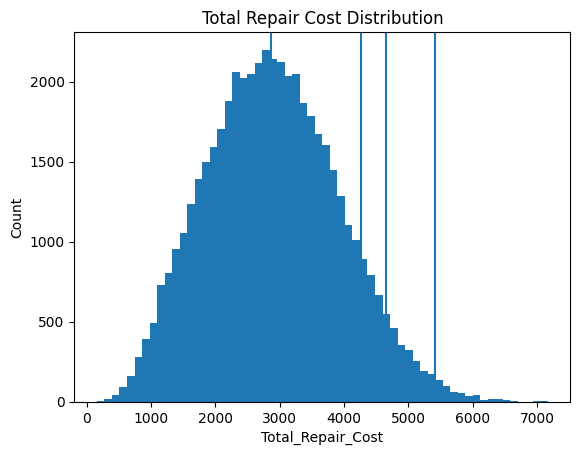

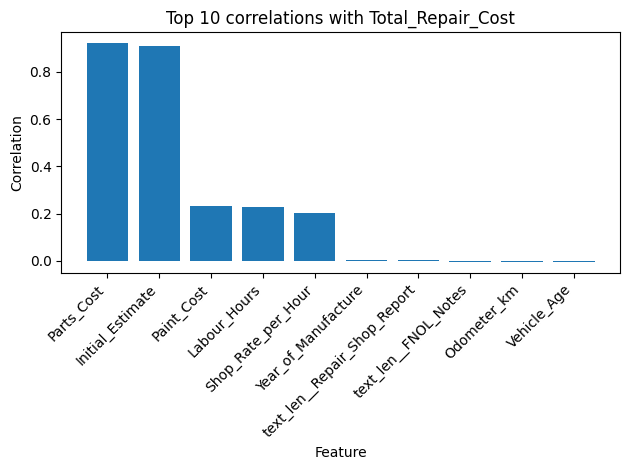

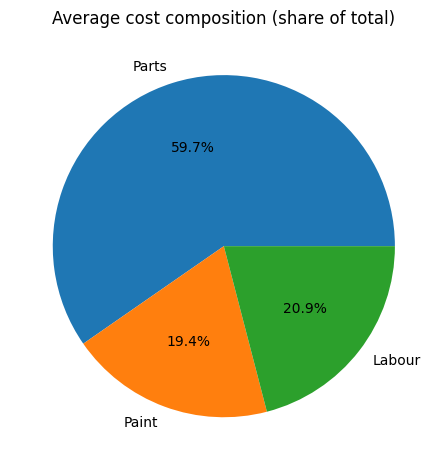

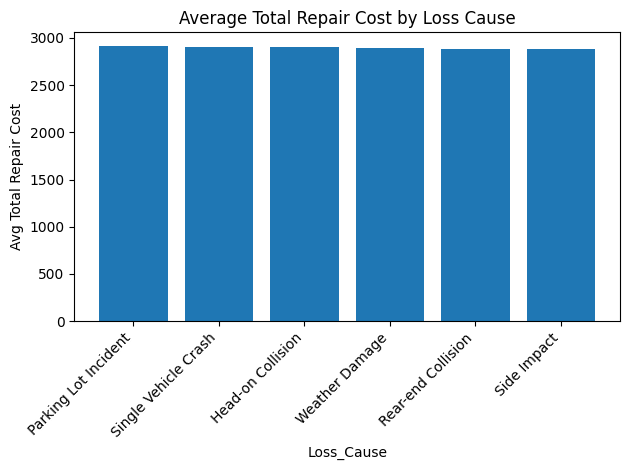

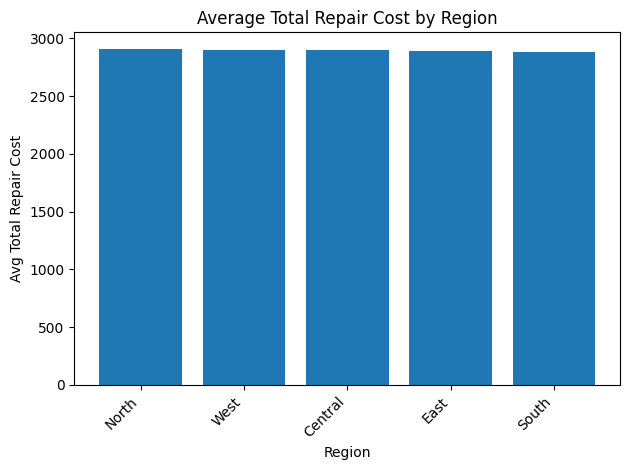

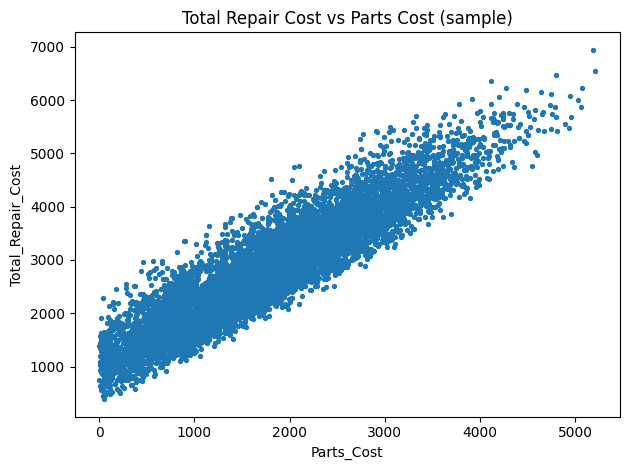

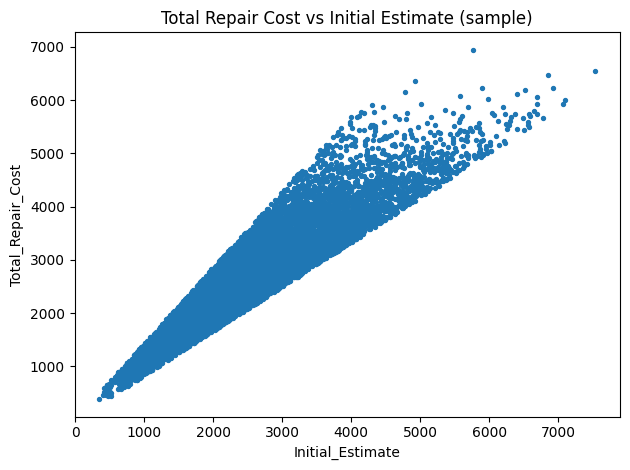

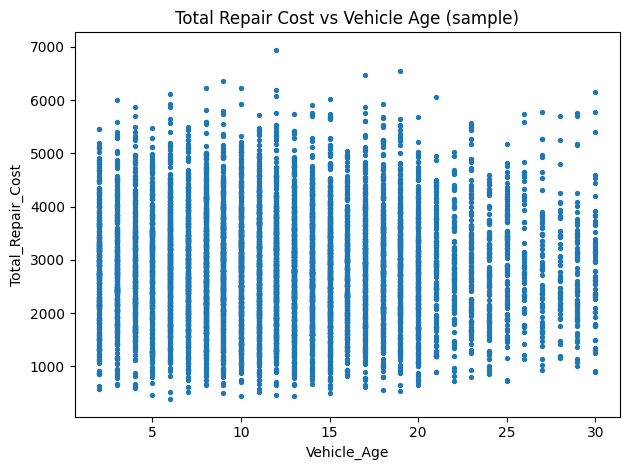

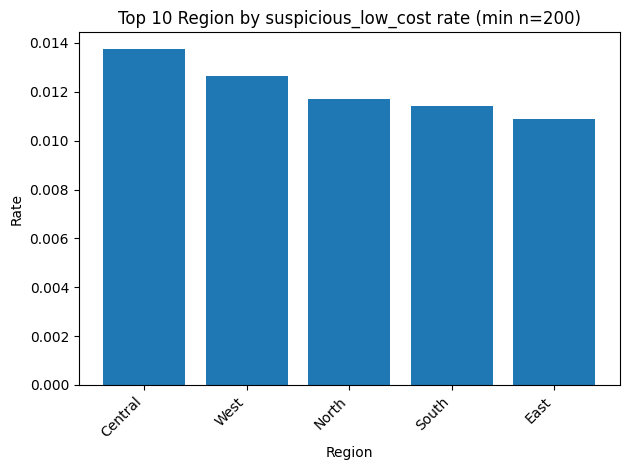

,feature,correlation
0,Parts_Cost,0.921024
1,Initial_Estimate,0.911124
2,Paint_Cost,0.232194
3,Labour_Hours,0.227752
4,Shop_Rate_per_Hour,0.200932
5,Year_of_Manufacture,0.004492
6,text_len__Repair_Shop_Report,0.003067
7,text_len__FNOL_Notes,-0.003937
8,Odometer_km,-0.003964
9,Vehicle_Age,-0.004492


,Loss_Cause,avg_cost,median_cost,claim_count
1,Parking Lot Incident,2912.624651,2869.97,8346
4,Single Vehicle Crash,2904.990144,2865.78,8386
0,Head-on Collision,2898.026459,2856.81,8319
5,Weather Damage,2892.969469,2859.61,8498
2,Rear-end Collision,2886.618838,2855.02,8195
3,Side Impact,2881.661116,2849.50,8256


,Region,avg_cost,median_cost,claim_count
2,North,2905.852297,2874.300,12653
4,West,2898.943690,2861.965,7350
0,Central,2894.151754,2856.720,12439
1,East,2893.615948,2852.750,9939
3,South,2884.236395,2846.200,7619


,Claim_ID,Total_Repair_Cost,Parts_Cost,Paint_Cost,Labour_Hours,Shop_Rate_per_Hour,suspicious_low_cost,any_outlier_iqr,invalid_any_cost_consistency


In [44]:
# -----------------------------
# Example usage in Jupyter
# -----------------------------
tables = run_eda_insights_with_plots(df_enriched)
display(tables["corr_df"].head(12))
display(tables["by_loss"])
display(tables["by_region"])
display(tables["anomalies"].head(10))

In [66]:
def compute_cost_contribution(
    df: pd.DataFrame,
    category_col: str,
    target: str = "Total_Repair_Cost",
    min_count: int = 100,
) -> pd.DataFrame:
    """
    Computes total cost contribution and percentage share
    by a categorical or binned variable.
    """
    agg = (
        df.groupby(category_col)[target]
        .agg(
            total_cost="sum",
            claim_count="count"
        )
        .reset_index()
    )

    # Filter low-volume noise
    # agg = agg[agg["claim_count"] >= min_count]

    total_spend = agg["total_cost"].sum()
    agg["cost_pct"] = agg["total_cost"] / total_spend * 100

    return agg.sort_values("total_cost", ascending=False)


In [67]:
def plot_cost_contribution(
    df_agg: pd.DataFrame,
    category_col: str,
    title: str,
    top_n: int = 30,
):
    plot_df = df_agg.head(top_n)

    plt.figure(figsize=(12, 4))
    plt.bar(plot_df[category_col].astype(str), plot_df["total_cost"])
    plt.title(title)
    plt.xlabel(category_col)
    plt.ylabel("Total Repair Cost")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Percentage view
    plt.figure(figsize=(12, 4))
    plt.bar(plot_df[category_col].astype(str), plot_df["cost_pct"])
    plt.title(f"{title} (% of Total Cost)")
    plt.xlabel(category_col)
    plt.ylabel("% of Total Repair Cost")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


In [58]:
def bin_odometer_10k(df: pd.DataFrame) -> pd.Series:
    max_km = int(np.ceil(df["Odometer_km"].max() / 10_000) * 10_000)
    bins = list(range(0, max_km + 10_000, 10_000))
    labels = [f"{bins[i]}–{bins[i+1]}" for i in range(len(bins) - 1)]

    return pd.cut(
        df["Odometer_km"],
        bins=bins,
        labels=labels,
        include_lowest=True,
        right=False,
    )


/var/folders/2s/8hh4qww16x916rmdl1bqtxdw0000gn/T/ipykernel_15110/3291223649.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(category_col)[target]


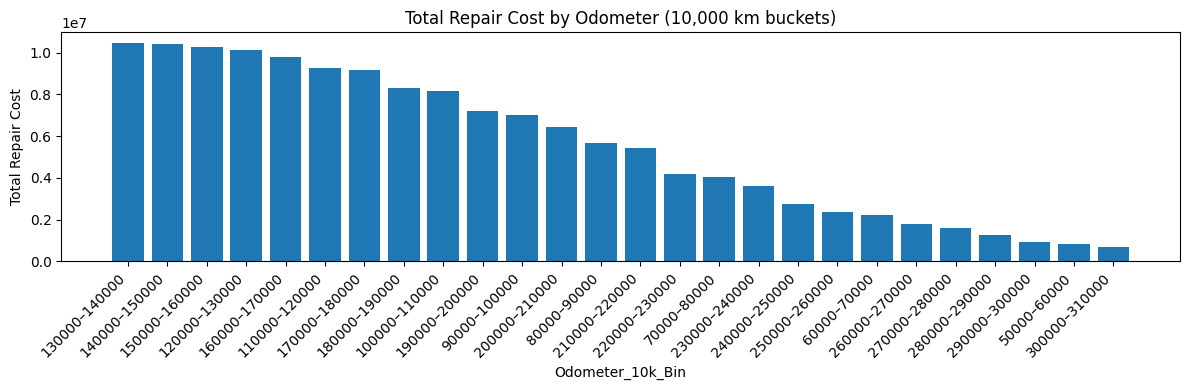

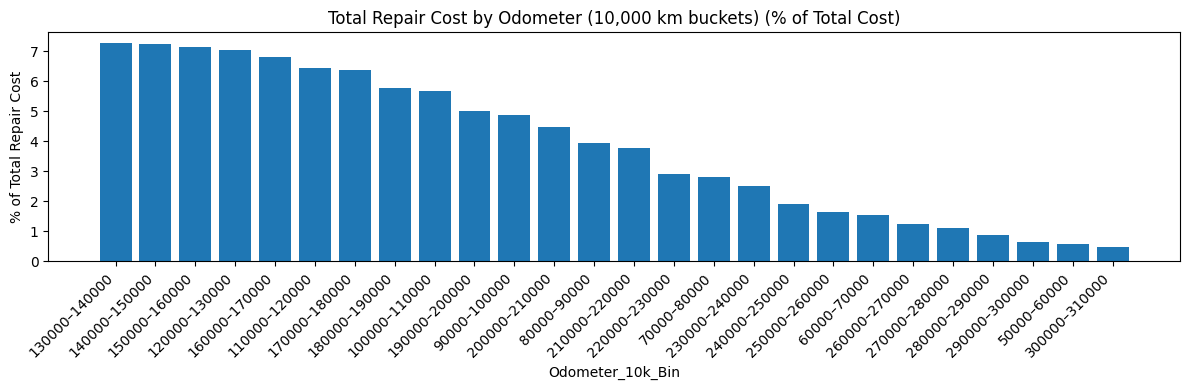

In [59]:
df_tmp = df_enriched.copy()
df_tmp["Odometer_10k_Bin"] = bin_odometer_10k(df_tmp)

odo_cost = compute_cost_contribution(
    df_tmp,
    category_col="Odometer_10k_Bin",
    min_count=200,
)

plot_cost_contribution(
    odo_cost,
    category_col="Odometer_10k_Bin",
    title="Total Repair Cost by Odometer (10,000 km buckets)",
)


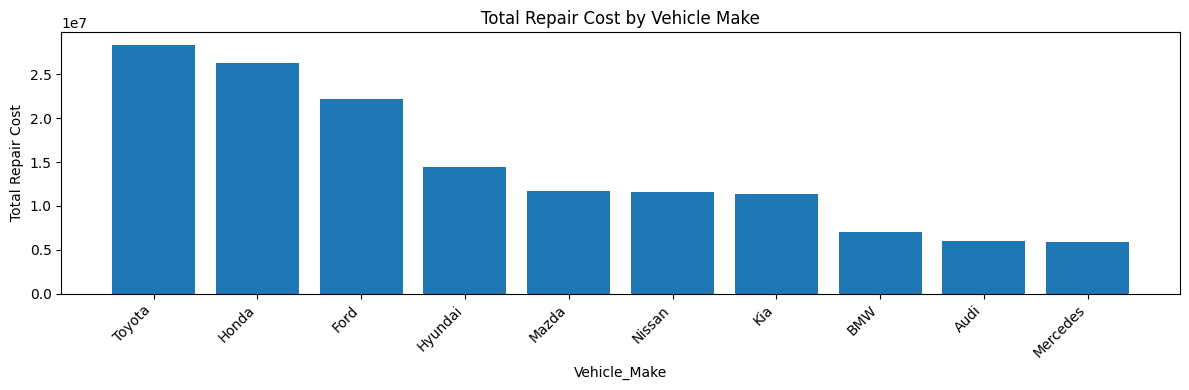

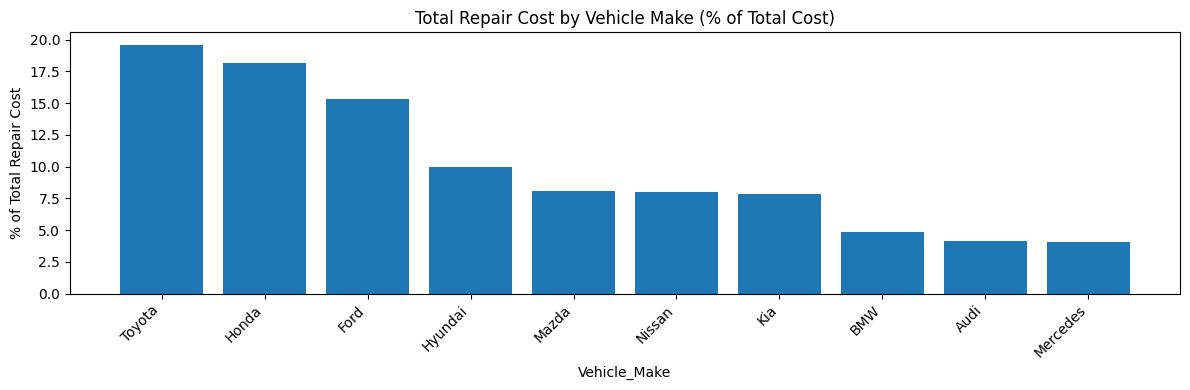

In [70]:
make_cost = compute_cost_contribution(
    df_enriched,
    category_col="Vehicle_Make",
    min_count=200,
)

plot_cost_contribution(
    make_cost,
    category_col="Vehicle_Make",
    title="Total Repair Cost by Vehicle Make",
)

In [72]:
make_cost.head(20)

,Vehicle_Make,total_cost,claim_count,cost_pct
9,Toyota,28380070.06,9824,19.598144
3,Honda,26270072.69,9041,18.141064
2,Ford,22232064.52,7664,15.352577
4,Hyundai,14479715.90,4977,9.999114
6,Mazda,11697618.45,4036,8.077909
8,Nissan,11593670.00,4008,8.006126
5,Kia,11385972.43,3949,7.862698
1,BMW,6985846.91,2431,4.824147
0,Audi,5943973.25,2037,4.104671
7,Mercedes,5840980.69,2033,4.033548


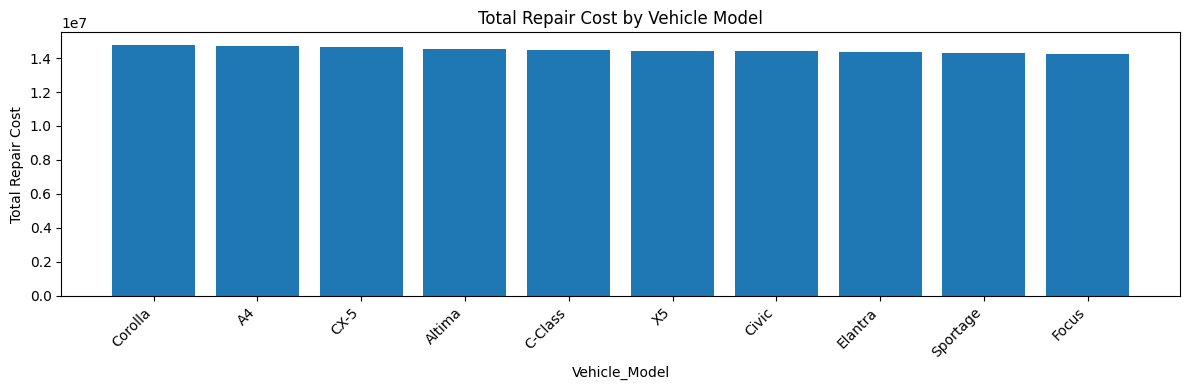

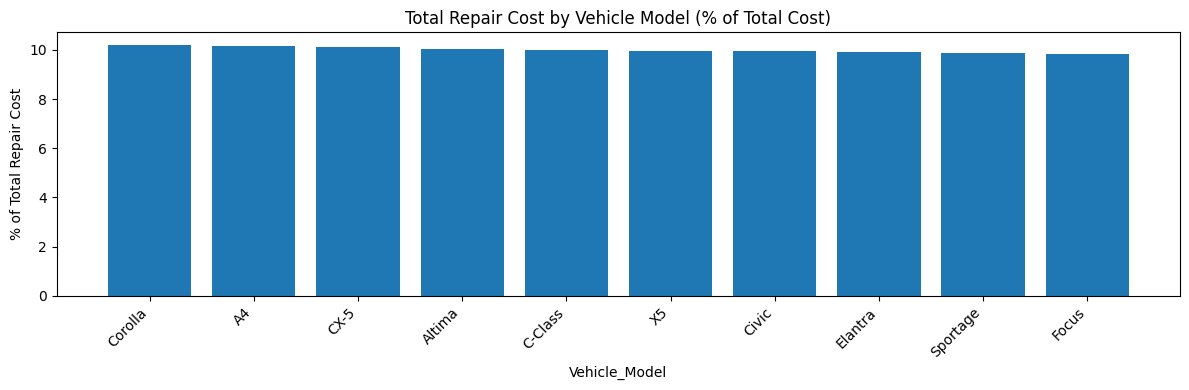

In [61]:
model_cost = compute_cost_contribution(
    df_enriched,
    category_col="Vehicle_Model",
    min_count=100,
)

plot_cost_contribution(
    model_cost,
    category_col="Vehicle_Model",
    title="Total Repair Cost by Vehicle Model",
    top_n=15,
)


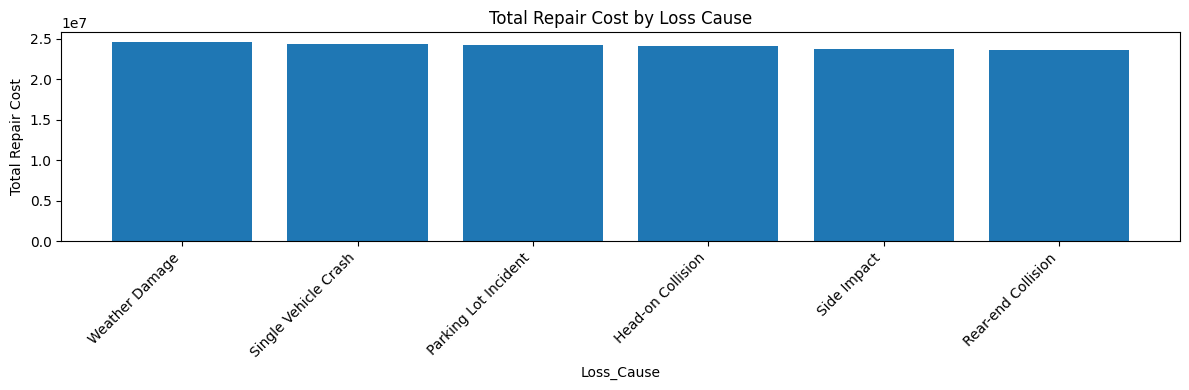

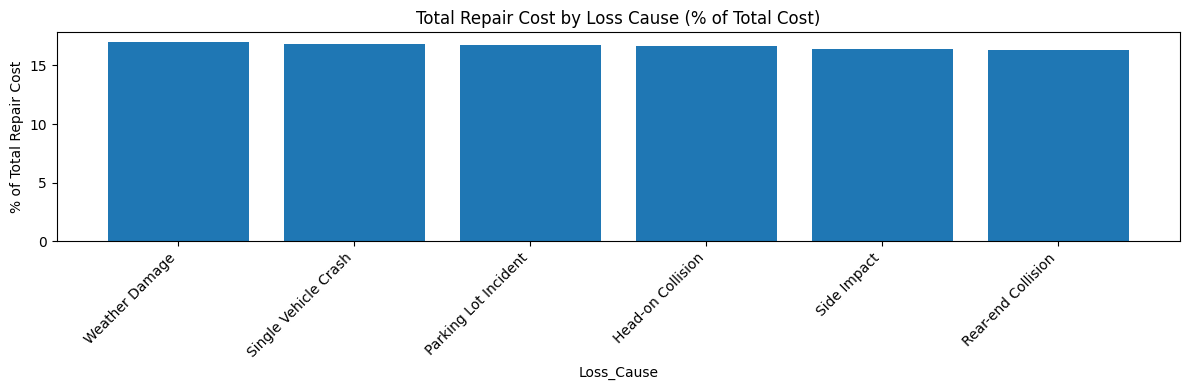

In [62]:
loss_cost = compute_cost_contribution(
    df_enriched,
    category_col="Loss_Cause",
    min_count=200,
)

plot_cost_contribution(
    loss_cost,
    category_col="Loss_Cause",
    title="Total Repair Cost by Loss Cause",
)


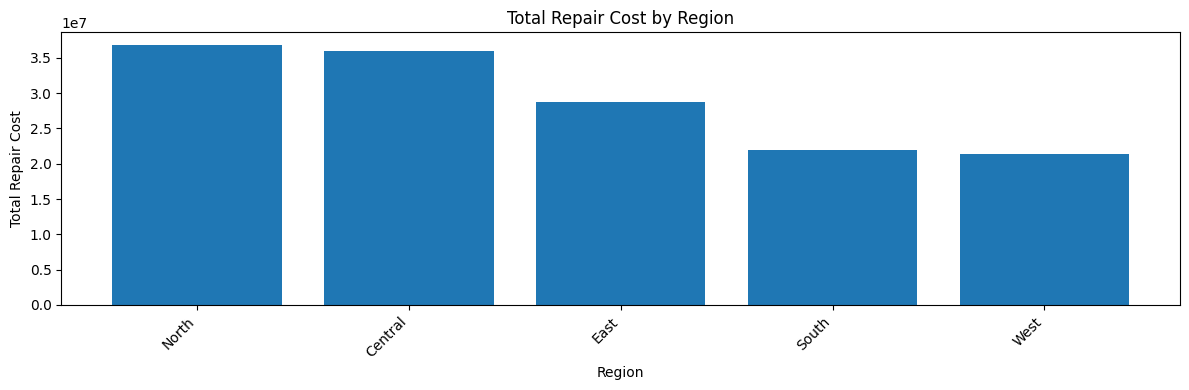

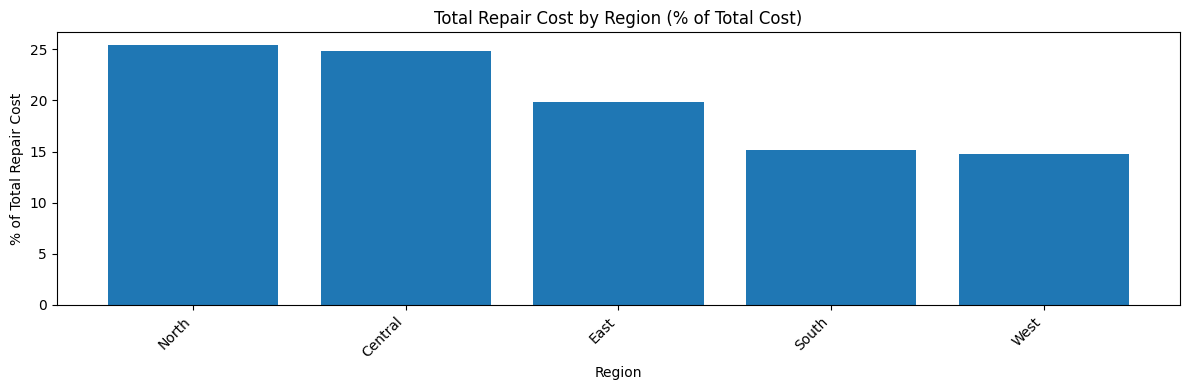

In [63]:
region_cost = compute_cost_contribution(
    df_enriched,
    category_col="Region",
    min_count=200,
)

plot_cost_contribution(
    region_cost,
    category_col="Region",
    title="Total Repair Cost by Region",
)


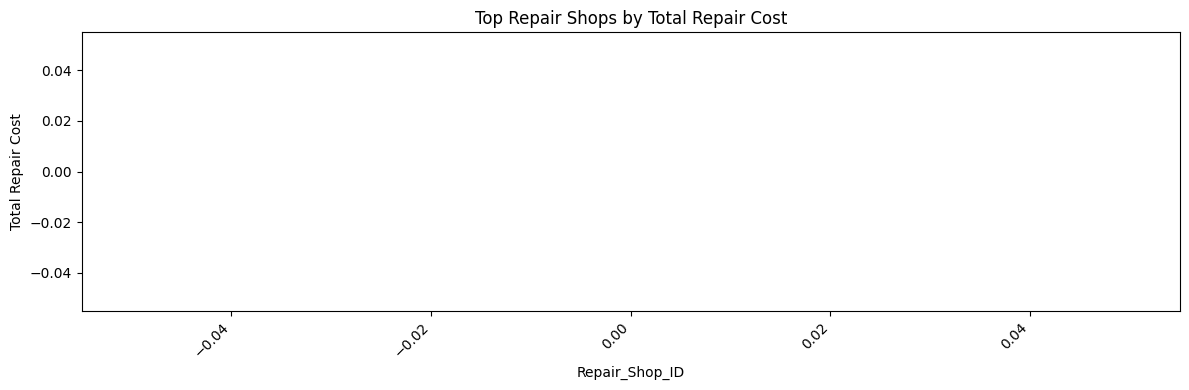

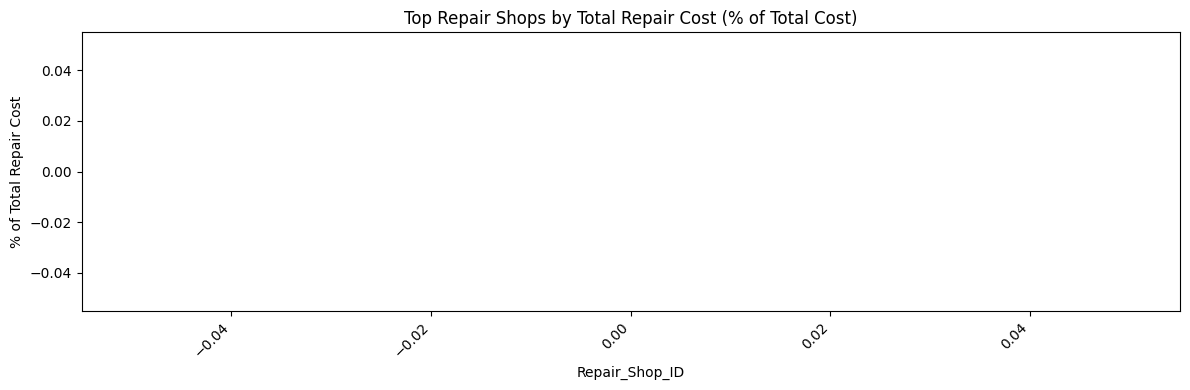

In [64]:
shop_cost = compute_cost_contribution(
    df_enriched,
    category_col="Repair_Shop_ID",
    min_count=50,
)

plot_cost_contribution(
    shop_cost,
    category_col="Repair_Shop_ID",
    title="Top Repair Shops by Total Repair Cost",
    top_n=15,
)


In [65]:
def plot_cumulative_cost_pareto(
    df_agg: pd.DataFrame,
    category_col: str,
    title: str,
    top_n: int = 20,
):
    plot_df = df_agg.head(top_n).copy()
    plot_df["cumulative_pct"] = plot_df["cost_pct"].cumsum()

    plt.figure(figsize=(12, 4))
    plt.bar(plot_df[category_col].astype(str), plot_df["cost_pct"])
    plt.plot(plot_df[category_col].astype(str), plot_df["cumulative_pct"], marker="o")
    plt.axhline(80)
    plt.title(title)
    plt.xlabel(category_col)
    plt.ylabel("% of Total Repair Cost")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


Estimate vs Total cost diffferences

In [74]:


def add_estimation_error_features(
    df: pd.DataFrame,
    total_col: str = "Total_Repair_Cost",
    estimate_col: str = "Initial_Estimate",
) -> pd.DataFrame:
    """
    Adds absolute and percentage estimation error features.
    """
    df = df.copy()

    df["estimate_error"] = df[total_col] - df[estimate_col]
    df["estimate_error_pct"] = df["estimate_error"] / df[estimate_col]

    df["is_under_estimate"] = df["estimate_error"] > 0
    df["is_over_estimate"] = df["estimate_error"] < 0
    df["is_exact_estimate"] = df["estimate_error"] == 0

    return df


def compute_estimate_direction_stats(df: pd.DataFrame) -> pd.DataFrame:
    """
    Computes % under-estimated, over-estimated, and exact claims.
    """
    total = len(df)

    stats = {
        "under_estimate_pct": df["is_under_estimate"].mean() * 100,
        "over_estimate_pct": df["is_over_estimate"].mean() * 100,
        "exact_estimate_pct": df["is_exact_estimate"].mean() * 100,
    }

    return pd.DataFrame(stats, index=["percentage"]).T

def compute_estimation_error_magnitude(df: pd.DataFrame) -> pd.DataFrame:
    """
    Computes mean and median error metrics for over/under estimates.
    """
    return pd.DataFrame({
        "mean_error": df["estimate_error"].mean(),
        "median_error": df["estimate_error"].median(),
        "mean_abs_error": df["estimate_error"].abs().mean(),
        "median_abs_error": df["estimate_error"].abs().median(),
        "mean_error_pct": df["estimate_error_pct"].mean() * 100,
        "median_error_pct": df["estimate_error_pct"].median() * 100,
    }, index=["value"]).T

def compute_cost_weighted_bias(df: pd.DataFrame) -> pd.DataFrame:
    """
    Computes cost-weighted under/over estimation impact.
    """
    under_cost = df.loc[df["is_under_estimate"], "estimate_error"].sum()
    over_cost = df.loc[df["is_over_estimate"], "estimate_error"].sum()  # negative
    total_abs_error = df["estimate_error"].abs().sum()

    return pd.DataFrame({
        "total_under_estimated_amount": under_cost,
        "total_over_estimated_amount": over_cost,
        "net_estimation_bias": under_cost + over_cost,
        "under_estimated_share_pct": (under_cost / total_abs_error) * 100 if total_abs_error > 0 else 0,
        "over_estimated_share_pct": (abs(over_cost) / total_abs_error) * 100 if total_abs_error > 0 else 0,
    }, index=["value"]).T


def estimate_error_by_dimension(
    df: pd.DataFrame,
    dimension: str,
    min_count: int = 100,
) -> pd.DataFrame:
    """
    Estimation bias grouped by a categorical dimension.
    """
    grouped = (
        df.groupby(dimension)
        .agg(
            claim_count=("estimate_error", "count"),
            mean_error=("estimate_error", "mean"),
            mean_abs_error=("estimate_error", lambda x: x.abs().mean()),
            under_estimate_rate=("is_under_estimate", "mean"),
        )
        .reset_index()
    )

    return grouped[grouped["claim_count"] >= min_count].sort_values(
        "mean_abs_error", ascending=False
    )



In [75]:
# Assume df_enriched exists from your cleaning pipeline

df_est = add_estimation_error_features(df_enriched)

direction_stats = compute_estimate_direction_stats(df_est)
error_magnitude = compute_estimation_error_magnitude(df_est)
cost_weighted_bias = compute_cost_weighted_bias(df_est)

# Optional segmentation
error_by_region = estimate_error_by_dimension(df_est, "Region")
error_by_loss = estimate_error_by_dimension(df_est, "Loss_Cause")

print("Percentage under vs over estimates:")
display(direction_stats)

print("\nError magnitude:")
display(error_magnitude)

print("\nCost-weighted bias:")
display(cost_weighted_bias)

print("\nRegions with highest estimation error:")
display(error_by_region.head(10))


Percentage under vs over estimates:


,percentage
under_estimate_pct,60.292
over_estimate_pct,39.708
exact_estimate_pct,0.000



Error magnitude:


,value
mean_error,148.172811
median_error,124.715000
mean_abs_error,376.729709
median_abs_error,319.665000
mean_error_pct,7.924499
median_error_pct,5.322849



Cost-weighted bias:


,value
total_under_estimated_amount,1.312256e+07
total_over_estimated_amount,-5.713922e+06
net_estimation_bias,7.408641e+06
under_estimated_share_pct,6.966567e+01
over_estimated_share_pct,3.033433e+01



Regions with highest estimation error:


,Region,claim_count,mean_error,mean_abs_error,under_estimate_rate
4,West,7350,152.235837,380.572408,0.606531
0,Central,12439,148.303068,376.930662,0.601978
2,North,12653,143.763594,376.053025,0.596143
1,East,9939,150.263946,375.521841,0.604286
3,South,7619,148.635145,375.394048,0.610448


<b> Model Development <b>

In [201]:
"""
Production Feature Engineering for FNOL Motor Repair Cost Prediction
-------------------------------------------------------------------

Key constraints (FNOL-safe):
- EXCLUDE leakage variables used to derive target:
  Labour_Hours, Parts_Cost, Paint_Cost, Shop_Rate_per_Hour
- EXCLUDE post-FNOL / post-inspection text:
  Repair_Shop_Report
- Keep features available at FNOL:
  vehicle details, claim context, FNOL notes, photos, initial estimate, region, repair shop id

This module provides:
- A sklearn-compatible transformer: FNOLFeatureEngineer (fit/transform)
- Robust feature creation with:
    * time features
    * vehicle age / odometer bins
    * frequency features (rarity)
    * historical cost indices (computed on TRAIN only during fit)
    * FNOL text features (lightweight keyword + length stats)
    * optional TF-IDF for FNOL_Notes (can be turned on/off)
- Output: numeric feature matrix (pandas DataFrame) ready for modeling.
"""

from __future__ import annotations

import re
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer


# -----------------------------
# Configuration
# -----------------------------
@dataclass(frozen=True)
class FeatureConfig:
    # Column names in your dataset
    claim_date_col: str = "Claim_Date"
    target_col: str = "Total_Repair_Cost"
    initial_estimate_col: str = "Initial_Estimate"
    fnol_notes_col: str = "FNOL_Notes"
    photos_col: str = "Photos_Available"

    #---Estimation-related---
    include_initial_estimate: bool = True


    # --- External extracted text features (from CSV) ---
    use_external_text_features: bool = True
    external_text_features_path: str = "/Users/asanga/suncorp/text_features_with_parts.csv"

    # Allowed FNOL structured features (raw)
    cat_cols: Tuple[str, ...] = (
        "Vehicle_Make",
        "Vehicle_Model",
        "Loss_Cause",
        "Repair_Shop_ID",
        "Region",
        "Liability_Assessment",
    )

    num_cols: Tuple[str, ...] = (
        "Year_of_Manufacture",
        "Vehicle_Age",
        "Odometer_km",
        "Initial_Estimate",
    )

    # Leakage / post-FNOL (excluded)
    excluded_cols: Tuple[str, ...] = (
        "Labour_Hours",
        "Parts_Cost",
        "Paint_Cost",
        "Shop_Rate_per_Hour",
        "Repair_Shop_Report",
        "Settlement_Time_Days",  # outcome / process after FNOL
    )

    # Binning
    odometer_bucket_size: int = 10_000
    vehicle_age_bins: Tuple[float, ...] = (-1, 3, 7, 12, 20, np.inf)
    vehicle_age_labels: Tuple[str, ...] = ("0_3", "4_7", "8_12", "13_20", "20_plus")

    # Low-count handling
    min_freq_for_common: int = 50  # for make/model/shop rarity flags
    smoothing_k: float = 20.0      # smoothing for cost indices

    # Text features
    use_tfidf: bool = False
    tfidf_max_features: int = 5000
    tfidf_ngram_range: Tuple[int, int] = (1, 2)

    # Keyword sets (simple, explainable FNOL NLP)
    severity_keywords: Tuple[str, ...] = ("minor", "moderate", "severe", "total", "write-off", "airbag")
    impact_keywords: Tuple[str, ...] = ("rear", "front", "side", "head-on", "collision", "impact")
    part_keywords: Tuple[str, ...] = (
        "bumper", "door", "hood", "bonnet", "fender", "quarter", "trunk", "boot",
        "windshield", "windscreen", "mirror", "wheel", "rim", "headlight", "taillight",
        "grille", "roof"
    )


# -----------------------------
# Utility helpers
# -----------------------------
def _to_datetime_safe(s: pd.Series, dayfirst: bool = True) -> pd.Series:
    return pd.to_datetime(s, errors="coerce", dayfirst=dayfirst)

def _safe_str_series(s: pd.Series) -> pd.Series:
    return s.astype("string").fillna("")

def _clip_lower(s: pd.Series, lower: float = 0.0) -> pd.Series:
    return s.where(s >= lower, lower)

def _bucket_odometer_10k(odometer: pd.Series, bucket_size: int) -> pd.Series:
    # Floor to nearest bucket_size (10k)
    # Example: 156,234 -> 150,000
    o = pd.to_numeric(odometer, errors="coerce")
    b = (np.floor(o / bucket_size) * bucket_size).astype("Int64")
    return b

def _bin_vehicle_age(age: pd.Series, bins: Tuple[float, ...], labels: Tuple[str, ...]) -> pd.Series:
    a = pd.to_numeric(age, errors="coerce")
    return pd.cut(a, bins=bins, labels=labels)

def _one_hot(df: pd.DataFrame, cols: List[str], prefix: str = "") -> pd.DataFrame:
    if not cols:
        return pd.DataFrame(index=df.index)
    return pd.get_dummies(df[cols], prefix=[f"{prefix}{c}" for c in cols], dummy_na=True)


# -----------------------------
# FNOL Feature Engineer
# -----------------------------
class FNOLFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    sklearn-compatible transformer.

    fit(df):
      - learns training-only aggregates (cost indices) to avoid leakage
      - learns TF-IDF vocabulary if enabled

    transform(df):
      - creates FNOL-safe features
      - returns a numeric pandas DataFrame
    """

    def __init__(self, cfg: Optional[FeatureConfig] = None, dayfirst_dates: bool = True):
        self.cfg = cfg or FeatureConfig()
        self.dayfirst_dates = dayfirst_dates

        # learned during fit
        self.global_cost_mean_: Optional[float] = None
        self.cost_index_maps_: Dict[str, pd.Series] = {}
        self.freq_maps_: Dict[str, pd.Series] = {}
        self.tfidf_: Optional[TfidfVectorizer] = None
        self.tfidf_feature_names_: Optional[List[str]] = None
        self.external_text_features_ = None
        self.external_feature_cols_ = None

        # one-hot schema learned on train
        self.ohe_columns_: Optional[List[str]] = None

    # ---------- FIT ----------
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        df = X.copy()

        # Global mean for smoothing / fallback
        if self.cfg.target_col in df.columns:
            self.global_cost_mean_ = float(pd.to_numeric(df[self.cfg.target_col], errors="coerce").mean())
        elif y is not None:
            self.global_cost_mean_ = float(pd.to_numeric(y, errors="coerce").mean())
        else:
            raise ValueError("fit requires target via df[Total_Repair_Cost] or y.")

        # Training-only cost indices (smoothed mean target by category)
        for col in ["Region", "Repair_Shop_ID", "Vehicle_Make", "Vehicle_Model", "Loss_Cause"]:
            if col in df.columns:
                self.cost_index_maps_[col] = self._fit_smoothed_mean(df, group_col=col)

        # Frequency maps (rarity)
        for col in ["Vehicle_Make", "Vehicle_Model", "Repair_Shop_ID"]:
            if col in df.columns:
                self.freq_maps_[col] = df[col].value_counts(dropna=False)

        # TF-IDF (optional) on FNOL_Notes only
        if self.cfg.use_tfidf:
            text = _safe_str_series(df.get(self.cfg.fnol_notes_col, pd.Series("", index=df.index)))
            self.tfidf_ = TfidfVectorizer(
                max_features=self.cfg.tfidf_max_features,
                ngram_range=self.cfg.tfidf_ngram_range,
                lowercase=True,
                stop_words="english",
            )
            self.tfidf_.fit(text.tolist())
            self.tfidf_feature_names_ = [f"tfidf__{t}" for t in self.tfidf_.get_feature_names_out().tolist()]

        
        # ---- Load external text features (train-time) ----
        self.external_text_features_: Optional[pd.DataFrame] = None
        self.external_feature_cols_: Optional[list[str]] = None
        
        if self.cfg.use_external_text_features:
            ext = pd.read_csv(self.cfg.external_text_features_path)
        
        # Keep only Claim_ID + engineered features (drop raw text fields)
        drop_cols = [c for c in ["FNOL_Notes", "Repair_Shop_Report"] if c in ext.columns]
        ext = ext.drop(columns=drop_cols)
        
        if "Claim_ID" not in ext.columns:
            raise ValueError("External feature file must contain Claim_ID")
            
        # Store as index for fast joins
        ext = ext.set_index("Claim_ID")
        
        self.external_text_features_ = ext
        self.external_feature_cols_ = ext.columns.tolist()

        # Learn one-hot columns on training set to keep consistent schema
        feats = self._build_features(df, fit_mode=True)
        self.ohe_columns_ = feats.columns.tolist()

        return self

    def _fit_smoothed_mean(self, df: pd.DataFrame, group_col: str) -> pd.Series:
        """
        Smoothed mean encoding:
          enc(g) = (sum_y_g + k * global_mean) / (count_g + k)
        """
        y = pd.to_numeric(df[self.cfg.target_col], errors="coerce")
        grp = df[group_col]
        stats = pd.DataFrame({"y": y, "g": grp})
        ag = stats.groupby("g")["y"].agg(["sum", "count"])

        k = float(self.cfg.smoothing_k)
        mu = float(self.global_cost_mean_)
        enc = (ag["sum"] + k * mu) / (ag["count"] + k)
        return enc

    # ---------- TRANSFORM ----------
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()
        # print(df.shape)

        feats = self._build_features(df, fit_mode=False)

        # Align to training one-hot schema
        if self.ohe_columns_ is None:
            raise RuntimeError("Transformer not fitted. Call fit() first.")

        feats = feats.reindex(columns=self.ohe_columns_, fill_value=0.0)

        # Ensure numeric
        for c in feats.columns:
            feats[c] = pd.to_numeric(feats[c], errors="coerce").fillna(0.0)

        return feats

    # ---------- FEATURE BUILD ----------
    def _build_features(self, df: pd.DataFrame, fit_mode: bool) -> pd.DataFrame:
        cfg = self.cfg
        out = pd.DataFrame(index=df.index)

        # ✅ Keep Claim_ID in out so we can MERGE (not concat) later
        if "Claim_ID" not in df.columns:
            raise ValueError("Claim_ID is required in input data.")
        out["Claim_ID"] = df["Claim_ID"].values

        # -------------------------
        # 1) Time features
        # -------------------------
        if cfg.claim_date_col in df.columns:
            dt = _to_datetime_safe(df[cfg.claim_date_col], dayfirst=self.dayfirst_dates)
            out["time__year"] = dt.dt.year.fillna(0).astype(int)
            out["time__month"] = dt.dt.month.fillna(0).astype(int)
            out["time__dayofweek"] = dt.dt.dayofweek.fillna(0).astype(int)
            out["time__is_weekend"] = dt.dt.dayofweek.isin([5, 6]).fillna(False).astype(int)
        else:
            out["time__year"] = 0
            out["time__month"] = 0
            out["time__dayofweek"] = 0
            out["time__is_weekend"] = 0

        # -------------------------
        # 2) Numeric FNOL features (safe)
        # -------------------------
        for col in cfg.num_cols:
            if (not cfg.include_initial_estimate) and (col == cfg.initial_estimate_col):
                continue
            if col in df.columns:
                out[f"num__{col}"] = pd.to_numeric(df[col], errors="coerce").fillna(0.0)
            else:
                out[f"num__{col}"] = 0.0

        # Estimate transformations (optional)
        if cfg.include_initial_estimate and cfg.initial_estimate_col in df.columns:
            est = pd.to_numeric(df[cfg.initial_estimate_col], errors="coerce").fillna(0.0)
            out["est__log1p"] = np.log1p(_clip_lower(est, 0.0))
            out["est__is_zero"] = (est <= 0).astype(int)
            out["est__rank_pct"] = est.rank(pct=True).fillna(0.0)

        # -------------------------
        # 3) Vehicle engineered buckets
        # -------------------------
        if "Vehicle_Age" in df.columns:
            out["veh__age_bin"] = _bin_vehicle_age(df["Vehicle_Age"], cfg.vehicle_age_bins, cfg.vehicle_age_labels).astype("string")
        else:
            out["veh__age_bin"] = "unknown"

        if "Odometer_km" in df.columns:
            out["veh__odometer_bucket_10k"] = _bucket_odometer_10k(df["Odometer_km"], cfg.odometer_bucket_size).astype("string")
        else:
            out["veh__odometer_bucket_10k"] = "unknown"

        if "Year_of_Manufacture" in df.columns:
            yom = pd.to_numeric(df["Year_of_Manufacture"], errors="coerce")
            out["veh__yom_missing"] = yom.isna().astype(int)
            out["veh__yom"] = yom.fillna(0).astype(int)
        else:
            out["veh__yom_missing"] = 1
            out["veh__yom"] = 0

        # -------------------------
        # 4) Photos available
        # -------------------------
        if cfg.photos_col in df.columns:
            out["fnol__photos_available"] = df[cfg.photos_col].astype(bool).fillna(False).astype(int)
        else:
            out["fnol__photos_available"] = 0

        # -------------------------
        # 5) Historical cost indices (TRAIN-learned; safe in transform)
        # -------------------------
        for col in ["Region", "Repair_Shop_ID", "Vehicle_Make", "Vehicle_Model", "Loss_Cause"]:
            key = f"idx__{col.lower()}_mean_cost"
            if col in df.columns and col in self.cost_index_maps_:
                enc_map = self.cost_index_maps_[col]
                out[key] = df[col].map(enc_map).fillna(self.global_cost_mean_ if self.global_cost_mean_ is not None else 0.0)
            else:
                out[key] = self.global_cost_mean_ if self.global_cost_mean_ is not None else 0.0

        for col in ["Vehicle_Make", "Vehicle_Model", "Repair_Shop_ID"]:
            key_cnt = f"freq__{col.lower()}_count"
            key_rare = f"freq__{col.lower()}_is_rare"
            if col in df.columns and col in self.freq_maps_:
                freq = self.freq_maps_[col]
                cnt = df[col].map(freq).fillna(0).astype(int)
                out[key_cnt] = cnt
                out[key_rare] = (cnt < cfg.min_freq_for_common).astype(int)
            else:
                out[key_cnt] = 0
                out[key_rare] = 1

        # -------------------------
        # 6) FNOL_Notes (light NLP features; explainable)
        # -------------------------
        text = _safe_str_series(df.get(cfg.fnol_notes_col, pd.Series("", index=df.index))).str.lower()

        out["txt__fnol_len_chars"] = text.str.len().astype(int)
        out["txt__fnol_len_words"] = text.str.split().map(len).astype(int)
        out["txt__fnol_is_missing"] = (text.str.len() == 0).astype(int)

        out["txt__severity_kw_count"] = text.apply(lambda s: sum(1 for w in cfg.severity_keywords if w in s)).astype(int)
        out["txt__impact_kw_count"] = text.apply(lambda s: sum(1 for w in cfg.impact_keywords if w in s)).astype(int)
        out["txt__parts_kw_count"] = text.apply(lambda s: sum(1 for w in cfg.part_keywords if w in s)).astype(int)

        out["txt__mentions_airbag"] = text.str.contains(r"\bairbag\b", regex=True).astype(int)
        out["txt__mentions_tow"] = text.str.contains(r"\btow|towed\b", regex=True).astype(int)
        out["txt__mentions_drivable"] = text.str.contains(r"\bdrivable\b", regex=True).astype(int)
        out["txt__mentions_not_drivable"] = text.str.contains(r"\bnot drivable|non[-\s]?drivable\b", regex=True).astype(int)

        # -------------------------
        # 7) One-hot for categorical + engineered bins
        # -------------------------
        cat_for_ohe = []
        for c in ["Vehicle_Make", "Loss_Cause", "Region", "Liability_Assessment", "veh__age_bin", "veh__odometer_bucket_10k"]:
            if c in df.columns or c in out.columns:
                cat_for_ohe.append(c)

        ohe_input = pd.DataFrame(index=df.index)
        for c in cat_for_ohe:
            ohe_input[c] = df[c].astype("string") if c in df.columns else out[c].astype("string")

        out_ohe = pd.get_dummies(ohe_input, prefix=[f"cat__{c}" for c in cat_for_ohe], dummy_na=True)

        if cfg.use_tfidf and (self.tfidf_ is not None):
            X_tfidf = self.tfidf_.transform(text.tolist())
            tfidf_df = pd.DataFrame(X_tfidf.toarray(), index=df.index, columns=self.tfidf_feature_names_)
            out = pd.concat([out, out_ohe, tfidf_df], axis=1)
        else:
            out = pd.concat([out, out_ohe], axis=1)

        # Drop excluded / target (safety)
        for c in cfg.excluded_cols:
            if c in out.columns:
                out = out.drop(columns=[c])
        if cfg.target_col in out.columns:
            out = out.drop(columns=[cfg.target_col])

        # ⚠️ IMPORTANT: don't drop Claim_ID yet (needed for merge)
        non_numeric = [c for c in out.columns if c != "Claim_ID" and out[c].dtype == "object"]
        if non_numeric:
            out = out.drop(columns=non_numeric)

        # -------------------------
        # External extracted text features join (MERGE on Claim_ID)
        # -------------------------
        if self.cfg.use_external_text_features:
            if self.external_text_features_ is None:
                raise RuntimeError("External text features enabled but not loaded. Ensure fit() was called.")

            # self.external_text_features_ should be indexed by Claim_ID (recommended from fit())
            ext = self.external_text_features_.copy()

            # Prefix external columns
            ext = ext.add_prefix("ext__").reset_index()  # Claim_ID becomes a column

            # ✅ Merge on Claim_ID (1:1) - prevents index misalignment issues
            out = out.merge(
                ext,
                on="Claim_ID",
                how="left",
                validate="1:1",
            )

            # Fill missing external features
            ext_cols = [c for c in out.columns if c.startswith("ext__")]
            out[ext_cols] = out[ext_cols].fillna(0.0)

        # ✅ Drop Claim_ID at the end (model should not see it)
        out = out.drop(columns=["Claim_ID"])

        # Ensure numeric
        for c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce").fillna(0.0)

        return out


In [183]:
# ----------------------------
# Metrics (incl. direction MAPE)
# ----------------------------
def mape(y_true, y_pred, eps: float = 1e-6) -> float:
    """Standard MAPE = mean(|y - yhat| / y)."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(y_true, eps)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100


def overall_mape(y_true, y_pred, eps: float = 1e-6) -> float:
    """Overall MAPE = sum(|error|) / sum(actual)."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = max(y_true.sum(), eps)
    return (np.abs(y_true - y_pred).sum() / denom) * 100


def directional_mape(y_true, y_pred, direction: str, eps: float = 1e-6) -> float:
    """
    MAPE split by forecast direction:
      - 'over'  : y_pred > y_true
      - 'under' : y_pred < y_true
    Returns NaN if no rows match the direction.
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    if direction == "over":
        mask = y_pred > y_true
    elif direction == "under":
        mask = y_pred < y_true
    else:
        raise ValueError("direction must be 'over' or 'under'")

    if mask.sum() == 0:
        return np.nan

    denom = np.maximum(y_true[mask], eps)
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denom) * 100


def regression_metrics(y_true, y_pred) -> dict:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),  # version-safe RMSE
        "R2": r2_score(y_true, y_pred),
        "MAPE_%": mape(y_true, y_pred),
        "Overall_MAPE_%": overall_mape(y_true, y_pred),
        "OverForecast_MAPE_%": directional_mape(y_true, y_pred, "over"),
        "UnderForecast_MAPE_%": directional_mape(y_true, y_pred, "under"),
    }

In [184]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [205]:
def get_models(random_state: int = 42):
    return {
        "Linear_Regression": LinearRegression(),

        "Random_Forest": RandomForestRegressor(
            n_estimators=300,
            max_depth=None,
            min_samples_leaf=50,
            random_state=random_state,
            n_jobs=-1,
        ),

        "Gradient_Boosting": GradientBoostingRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            random_state=random_state,
        ),

        # "SVR_RBF": SVR(
        #     kernel="rbf",
        #     C=10.0,
        #     epsilon=0.1,
        # ),
    }


In [206]:
# ----------------------------
# Evaluation table (train + test)
# ----------------------------
def evaluate_models(X_train, y_train, X_test, y_test) -> pd.DataFrame:
    results = []
    models = get_models()

    for name, model in models.items():
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        tr = regression_metrics(y_train, y_train_pred)
        te = regression_metrics(y_test, y_test_pred)

        results.append({
            "Model": name,

            # Train
            "Train_MAE": tr["MAE"],
            "Train_RMSE": tr["RMSE"],
            "Train_R2": tr["R2"],
            "Train_MAPE_%": tr["MAPE_%"],
            "Train_Overall_MAPE_%": tr["Overall_MAPE_%"],
            "Train_OverForecast_MAPE_%": tr["OverForecast_MAPE_%"],
            "Train_UnderForecast_MAPE_%": tr["UnderForecast_MAPE_%"],

            # Test
            "Test_MAE": te["MAE"],
            "Test_RMSE": te["RMSE"],
            "Test_R2": te["R2"],
            "Test_MAPE_%": te["MAPE_%"],
            "Test_Overall_MAPE_%": te["Overall_MAPE_%"],
            "Test_OverForecast_MAPE_%": te["OverForecast_MAPE_%"],
            "Test_UnderForecast_MAPE_%": te["UnderForecast_MAPE_%"],
        })

    return pd.DataFrame(results).sort_values("Test_Overall_MAPE_%", ascending=True)

In [207]:
# ------------------------------------
# Feature engineering (already built)
# ------------------------------------
cfg = FeatureConfig(
    use_tfidf=False, 
    include_initial_estimate=False 
    ,use_external_text_features=True,
    external_text_features_path="/Users/asanga/suncorp/text_features_with_parts.csv")  # keep explainable
    
fe = FNOLFeatureEngineer(cfg=cfg, dayfirst_dates=True)

# Train / test split
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df_filtered_strict, test_size=0.2, random_state=42
)

# Fit FE only on training data (important)
fe.fit(df_train)

X_train = fe.transform(df_train)
y_train = df_train[cfg.target_col].astype(float)

X_test = fe.transform(df_test)
y_test = df_test[cfg.target_col].astype(float)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (39481, 132)
Test shape: (9871, 132)


In [209]:
X_train.shape
# df_test.shape

(39481, 132)

,Model,Train_MAE,Train_RMSE,Train_R2,Train_MAPE_%,Train_Overall_MAPE_%,Train_OverForecast_MAPE_%,Train_UnderForecast_MAPE_%,Test_MAE,Test_RMSE,Test_R2,Test_MAPE_%,Test_Overall_MAPE_%,Test_OverForecast_MAPE_%,Test_UnderForecast_MAPE_%
2,Gradient_Boosting,804.131400,993.884344,0.070978,36.407081,27.766642,52.039930,20.087117,863.630642,1071.255558,-0.056000,39.507030,29.725187,56.734866,21.650078
0,Linear_Regression,812.310831,1004.173516,0.051643,36.771426,28.049077,52.549209,20.295150,863.959497,1071.198811,-0.055889,39.534987,29.736505,56.589082,21.735879
1,Random_Forest,771.530641,954.593207,0.142980,34.923651,26.640938,49.909484,19.277557,864.820978,1072.477454,-0.058411,39.555105,29.766157,56.746890,21.706603


Best model: Gradient_Boosting


,feature,importance
0,idx__repair_shop_id_mean_cost,0.720426
1,num__Odometer_km,0.047082
2,ext__fnol__len_chars,0.021049
3,ext__shop__len_chars,0.018756
4,txt__fnol_len_chars,0.015947
5,freq__repair_shop_id_count,0.015194
6,time__month,0.011906
7,idx__vehicle_model_mean_cost,0.007433
8,ext__fnol__len_words,0.006662
9,time__dayofweek,0.006371


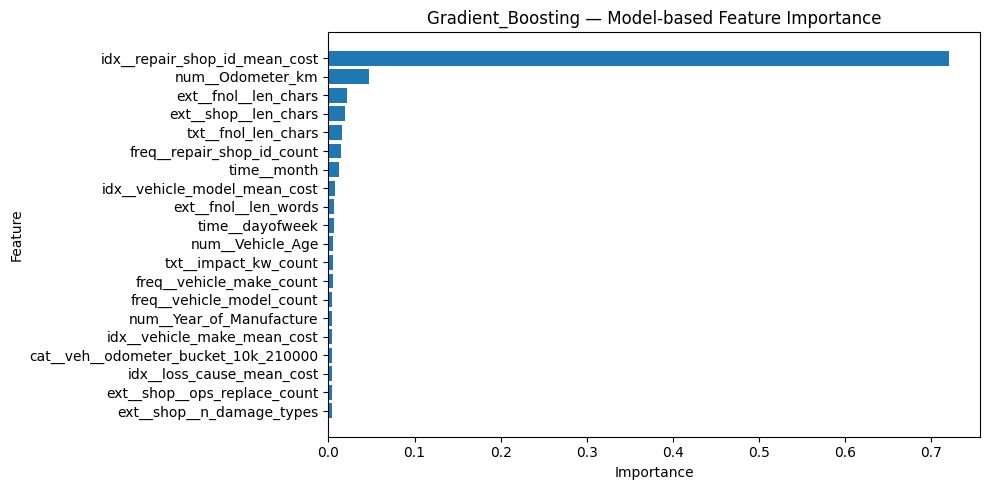


Linear_Regression top features:


,feature,importance
0,cat__veh__odometer_bucket_10k_330000,841.856522
1,ext__shop__n_components,435.112239
2,ext__part__panel,423.306007
3,ext__part__fender,290.288487
4,ext__part__windshield,285.050077
5,ext__part__door,284.052981
6,ext__part__roof,281.336220
7,ext__part__headlight,280.507223
8,ext__part__bumper,279.679584
9,ext__part__mirror,273.948746



Random_Forest top features:


,feature,importance
0,idx__repair_shop_id_mean_cost,0.399551
1,num__Odometer_km,0.065821
2,ext__shop__len_chars,0.042838
3,freq__repair_shop_id_count,0.032099
4,time__month,0.031863
5,idx__vehicle_model_mean_cost,0.026174
6,txt__fnol_len_chars,0.025691
7,ext__fnol__len_chars,0.025627
8,time__dayofweek,0.021372
9,freq__vehicle_model_count,0.021262



Gradient_Boosting top features:


,feature,importance
0,idx__repair_shop_id_mean_cost,0.720426
1,num__Odometer_km,0.047082
2,ext__fnol__len_chars,0.021049
3,ext__shop__len_chars,0.018756
4,txt__fnol_len_chars,0.015947
5,freq__repair_shop_id_count,0.015194
6,time__month,0.011906
7,idx__vehicle_model_mean_cost,0.007433
8,ext__fnol__len_words,0.006662
9,time__dayofweek,0.006371


In [210]:
# ============================================================
# Feature Importance
# - For tree models: model.feature_importances_
# - For linear regression: abs(coefficients)
# - For others (SVR): permutation importance (robust fallback)
# ============================================================
def get_model_based_feature_importance(model, feature_names: list[str]) -> pd.DataFrame | None:
    """
    Returns feature importance if model exposes:
      - feature_importances_ (tree models)
      - coef_ (linear models)
    Else returns None.
    """
    if hasattr(model, "feature_importances_"):
        imp = np.asarray(model.feature_importances_, dtype=float)
        return (
            pd.DataFrame({"feature": feature_names, "importance": imp})
            .sort_values("importance", ascending=False)
            .reset_index(drop=True)
        )

    if hasattr(model, "coef_"):
        coef = np.asarray(model.coef_, dtype=float)
        # If multi-output (unlikely here), collapse
        if coef.ndim > 1:
            coef = np.mean(np.abs(coef), axis=0)
        else:
            coef = np.abs(coef)
        return (
            pd.DataFrame({"feature": feature_names, "importance": coef})
            .sort_values("importance", ascending=False)
            .reset_index(drop=True)
        )

    return None


def get_permutation_importance_df(
    model,
    X: pd.DataFrame,
    y: pd.Series,
    *,
    n_repeats: int = 5,
    random_state: int = 42,
    scoring: str = "neg_mean_absolute_error",
) -> pd.DataFrame:
    """
    Model-agnostic feature importance via permutation.
    Uses MAE by default (neg_mean_absolute_error).
    """
    r = permutation_importance(
        model,
        X,
        y,
        n_repeats=n_repeats,
        random_state=random_state,
        scoring=scoring,
        n_jobs=-1,
    )
    return (
        pd.DataFrame(
            {
                "feature": X.columns,
                "importance": r.importances_mean,
                "importance_std": r.importances_std,
            }
        )
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )


def plot_top_feature_importance(imp_df: pd.DataFrame, top_n: int = 20, title: str = "Feature Importance") -> None:
    """
    Matplotlib-only plot (no custom colors).
    """
    import matplotlib.pyplot as plt

    d = imp_df.head(top_n).iloc[::-1]  # reverse for horizontal bar chart
    plt.figure(figsize=(10, max(4, top_n * 0.25)))
    plt.barh(d["feature"].astype(str), d["importance"].astype(float))
    plt.title(title)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


# ============================================================
# End-to-end run example (drop into your notebook)
# Assumes you already created:
#   X_train, y_train, X_test, y_test
# ============================================================

# 1) Evaluate models and show final comparison table
results = evaluate_models(X_train, y_train, X_test, y_test)
display(results)

# 2) Fit the best model (lowest Test_Overall_MAPE_%)
best_model_name = results.iloc[0]["Model"]
models = get_models()
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

print("Best model:", best_model_name)

# 3) Feature importance for best model
feature_names = list(X_train.columns)

imp = get_model_based_feature_importance(best_model, feature_names)

if imp is not None:
    display(imp.head(25))
    plot_top_feature_importance(imp, top_n=20, title=f"{best_model_name} — Model-based Feature Importance")
else:
    # SVR or other models without native importances:
    perm_imp = get_permutation_importance_df(
        best_model,
        X_test,   # use test set to reflect generalisation
        y_test,
        n_repeats=5,
        scoring="neg_mean_absolute_error",
    )
    display(perm_imp.head(25))
    plot_top_feature_importance(perm_imp, top_n=20, title=f"{best_model_name} — Permutation Importance (MAE)")

# 4) (Optional) Get importances for ALL models (model-based where possible, permutation otherwise)
all_importances = {}
for name, model in get_models().items():
    model.fit(X_train, y_train)
    imp_df = get_model_based_feature_importance(model, feature_names)
    if imp_df is None:
        imp_df = get_permutation_importance_df(model, X_test, y_test, n_repeats=3, scoring="neg_mean_absolute_error")
    all_importances[name] = imp_df

# Example: view top features for each model quickly
for name, imp_df in all_importances.items():
    print(f"\n{name} top features:")
    display(imp_df.head(10))

In [125]:
X_train.columns

Index(['time__year', 'time__month', 'time__dayofweek', 'time__is_weekend',
       'num__Year_of_Manufacture', 'num__Vehicle_Age', 'num__Odometer_km',
       'veh__yom_missing', 'veh__yom', 'fnol__photos_available',
       'idx__region_mean_cost', 'idx__repair_shop_id_mean_cost',
       'idx__vehicle_make_mean_cost', 'idx__vehicle_model_mean_cost',
       'idx__loss_cause_mean_cost', 'freq__vehicle_make_count',
       'freq__vehicle_make_is_rare', 'freq__vehicle_model_count',
       'freq__vehicle_model_is_rare', 'freq__repair_shop_id_count',
       'freq__repair_shop_id_is_rare', 'txt__fnol_len_chars',
       'txt__fnol_len_words', 'txt__fnol_is_missing', 'txt__severity_kw_count',
       'txt__impact_kw_count', 'txt__parts_kw_count', 'txt__mentions_airbag',
       'txt__mentions_tow', 'txt__mentions_drivable',
       'txt__mentions_not_drivable'],
      dtype='object')

In [179]:
train_with_target = X_train.copy()
# train_with_target["Total_Repair_Cost"] = y_train.values

train_with_target.to_csv(
    "/Users/asanga/suncorp/train_with_target_ext.csv",
    index=False
)


Model explainability

In [211]:
pip install shap

432934.20s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 555.6/555.6 kB 17.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 4.6 MB/s  0:00:07 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 13.3 MB/s  0:00:00
Using cached typing_extensions-4.15.0-py3-none-any.whl (44 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [shap]6/7 [shap]]te]
Note: you may need to restart the kernel to use updated packages.


In [212]:
import shap

/Users/asanga/suncorp/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [213]:
def get_shap_background(X_train: pd.DataFrame, max_rows: int = 2000, random_state: int = 42) -> pd.DataFrame:
    if len(X_train) > max_rows:
        return X_train.sample(max_rows, random_state=random_state)
    return X_train


In [214]:
def build_shap_explainer(model, X_train: pd.DataFrame):
    """
    Creates an appropriate SHAP explainer based on model type.
    TreeExplainer for tree models, LinearExplainer for linear models.
    Falls back to shap.Explainer if needed.
    """
    # Tree-based models
    if hasattr(model, "feature_importances_"):
        return shap.TreeExplainer(model)

    # Linear models
    if hasattr(model, "coef_"):
        bg = get_shap_background(X_train)
        return shap.LinearExplainer(model, bg)

    # Generic fallback (can be slow)
    bg = get_shap_background(X_train, max_rows=500)
    return shap.Explainer(model.predict, bg)


In [215]:
def shap_global_explanations(model, X_train: pd.DataFrame, X_test: pd.DataFrame, max_test_rows: int = 3000):
    """
    Produces:
    - SHAP summary bar plot (global importance)
    - SHAP beeswarm plot (direction + distribution)
    """
    explainer = build_shap_explainer(model, X_train)

    # Sample test rows for speed
    X_vis = X_test.sample(max_test_rows, random_state=42) if len(X_test) > max_test_rows else X_test

    shap_values = explainer(X_vis)

    # Global importance (bar)
    shap.summary_plot(shap_values, X_vis, plot_type="bar", show=True)

    # Global distribution & direction (beeswarm)
    shap.summary_plot(shap_values, X_vis, show=True)

    return explainer, shap_values, X_vis


In [216]:
def shap_individual_explanation(
    explainer,
    X_row: pd.DataFrame,
    title: str = "Individual claim explanation",
):
    """
    Produces a waterfall plot explaining one prediction.
    X_row must be a single-row DataFrame (shape: 1 x n_features).
    """
    shap_values_row = explainer(X_row)

    # Waterfall plot (best for single prediction)
    plt.figure()
    shap.plots.waterfall(shap_values_row[0], show=True)
    plt.title(title)
    plt.show()

    return shap_values_row


In [219]:
pred

np.float64(2592.798568288969)

In [222]:
X_one.index[0]

np.int64(0)

Best model: Gradient_Boosting


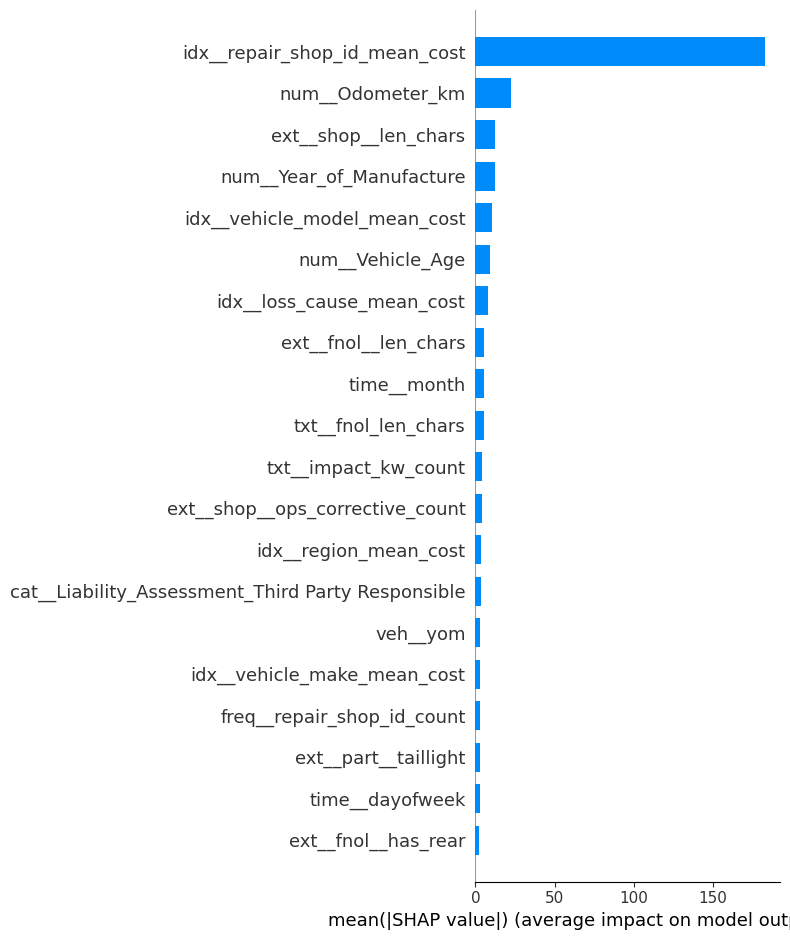

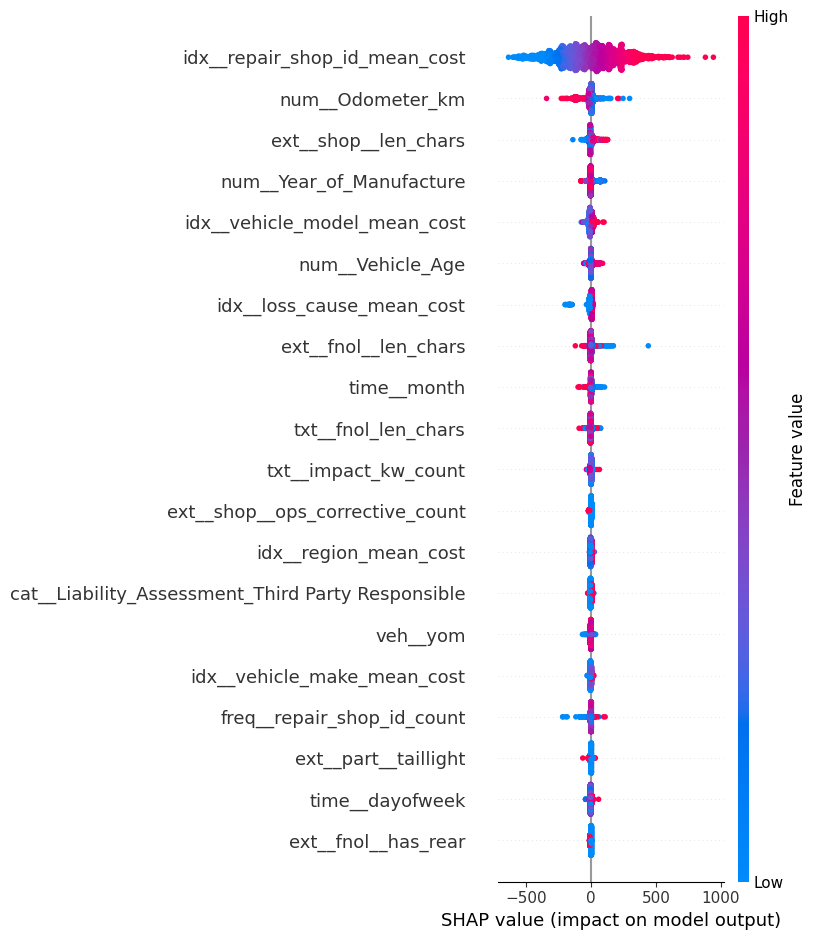

Example claim index: 0
Prediction: 2592.80
Actual: 2597.15


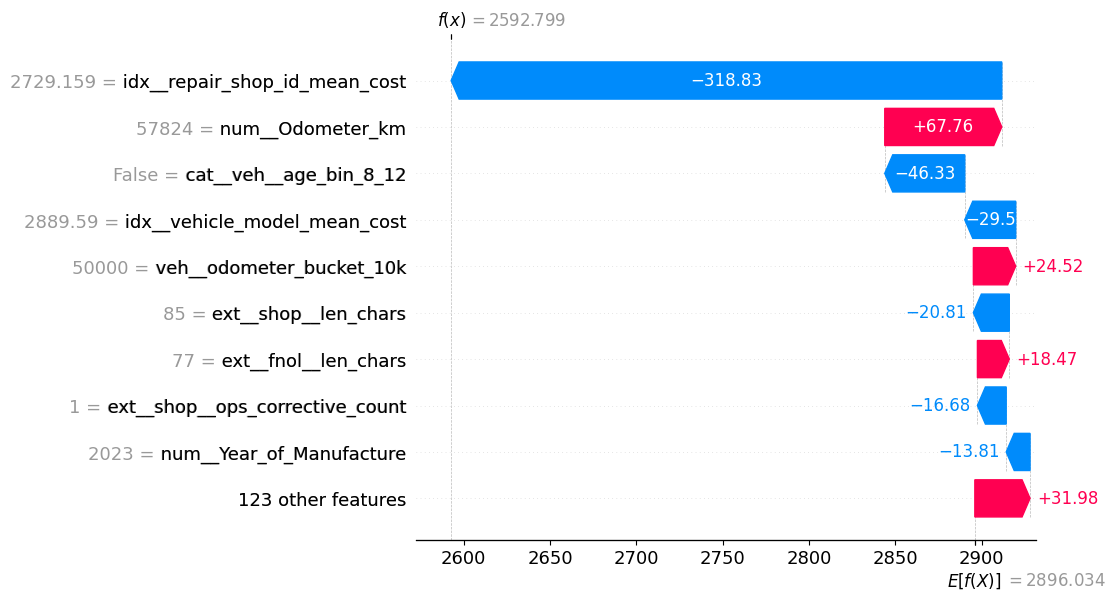

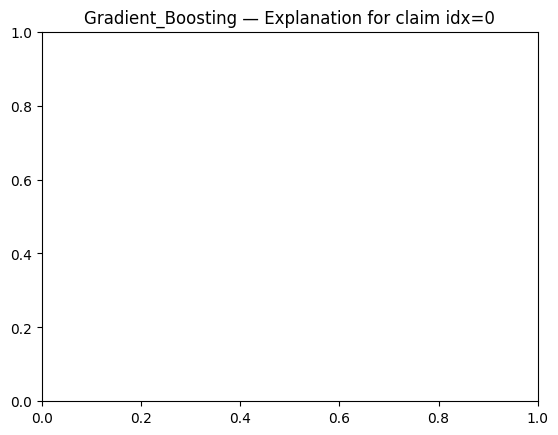

In [223]:
# Fit best model (already in your pipeline)
best_model_name = results.iloc[0]["Model"]
best_model = get_models()[best_model_name]
best_model.fit(X_train, y_train)

print("Best model:", best_model_name)

# --- GLOBAL EXPLANATIONS (feature-level drivers) ---
explainer, shap_values, X_vis = shap_global_explanations(best_model, X_train, X_test)

# --- INDIVIDUAL EXPLANATION (single claim) ---

row_pos = 0  # position, NOT index label

X_one = X_test.iloc[[row_pos]]
pred = best_model.predict(X_one)[0]
actual = y_test.iloc[row_pos]

print(f"Example claim index: {idx}")
print(f"Prediction: {pred:.2f}")
if actual is not None:
    print(f"Actual: {actual:.2f}")

_ = shap_individual_explanation(explainer, X_one, title=f"{best_model_name} — Explanation for claim idx={idx}")


In [ ]:
INCLUDE_MAKE_MODEL = True  # set False if you want to exclude make/model extraction

EXTRACTION_JSON_SCHEMA = {
    "name": "damage_extraction",
    "strict": True,
    "schema": {
        "type": "object",
        "additionalProperties": False,
        "properties": (
            {
                "make": {"type": "string"},
                "model": {"type": "string"},
                "components": {"type": "array", "items": {"type": "string"}},
                "damage_types": {"type": "array", "items": {"type": "string"}},
                "severity": {
                    "type": "array",
                    "items": {"type": "string", "enum": ["minor", "medium", "severe"]},
                },
                "location": {"type": "array", "items": {"type": "string"}},
            }
            if INCLUDE_MAKE_MODEL
            else {
                "components": {"type": "array", "items": {"type": "string"}},
                "damage_types": {"type": "array", "items": {"type": "string"}},
                "severity": {
                    "type": "array",
                    "items": {"type": "string", "enum": ["minor", "medium", "severe"]},
                },
                "location": {"type": "array", "items": {"type": "string"}},
            }
        ),
        "required": (
            ["make", "model", "components", "damage_types", "severity", "location"]
            if INCLUDE_MAKE_MODEL
            else ["components", "damage_types", "severity", "location"]
        ),
    },
}

from __future__ import annotations

import hashlib
import json
import time
from dataclasses import dataclass
from typing import Any, Dict, Optional

from openai import OpenAI

@dataclass(frozen=True)
class LLMConfig:
    model: str = "gpt-4o-mini"   # choose a model that supports structured outputs
    max_retries: int = 3
    retry_backoff_s: float = 0.8
    temperature: float = 0.0     # deterministic extraction
    timeout_s: float = 30.0
    cache_enabled: bool = True


def _sha(text: str) -> str:
    return hashlib.sha256(text.encode("utf-8")).hexdigest()


class OpenAIJSONSchemaExtractor:
    """
    Calls OpenAI and returns a Python dict matching EXTRACTION_JSON_SCHEMA.
    Uses Structured Outputs (json_schema) for strong guarantees. :contentReference[oaicite:2]{index=2}
    """
    def __init__(self, cfg: LLMConfig, json_schema: Dict[str, Any]):
        self.cfg = cfg
        self.client = OpenAI()
        self.json_schema = json_schema
        self._cache: Dict[str, Dict[str, Any]] = {}

    def extract(self, text: str) -> Dict[str, Any]:
        text = (text or "").strip()
        if not text:
            return self._empty()

        key = _sha(text)
        if self.cfg.cache_enabled and key in self._cache:
            return self._cache[key]

        prompt = (prompt = f"""You are a senior motor insurance claims assessor with deep experience in
        vehicle damage assessment, repair estimation, and claims triage.
        
        Your task is to read a free-text claim description and extract structured,
        factual information that would help estimate repair cost and complexity.
        Focus only on information that is explicitly stated or clearly implied.
        Do NOT guess or infer details that are not supported by the text.
        
        Return your response as VALID JSON only, strictly following the schema below.
        Do not include any explanation, commentary, or additional fields.
        
        SCHEMA (do not change keys or structure):{json.dumps(self.json_schema["schema"], indent=2)}
        
        EXTRACTION GUIDELINES:
        - Only extract vehicle make or model if clearly mentioned in the text.
        - Components should refer to physical vehicle parts, not repair actions.
        - Damage types should describe the nature of the damage, not repair steps.
        - Severity must be one of: minor, medium, severe.
        - Location should capture spatial context (front/rear/left/right/etc.).
        - If information is missing, return empty strings or empty lists.
        - Use lower-case values for list items.
        - Do not duplicate items.
        
        CLAIM DESCRIPTION:
        \"\"\"
        {text}
        \"\"\"
        """.strip()
        )

        last_err: Optional[Exception] = None
        for attempt in range(self.cfg.max_retries):
            try:
                resp = self.client.chat.completions.create(
                    model=self.cfg.model,
                    temperature=self.cfg.temperature,
                    messages=[
                        {"role": "system", "content": "You are a precise information extraction engine."},
                        {"role": "user", "content": prompt},
                    ],
                    response_format={"type": "json_schema", "json_schema": self.json_schema},
                    timeout=self.cfg.timeout_s,
                )

                # The SDK returns JSON as text in message content; parse it
                content = resp.choices[0].message.content
                obj = json.loads(content)

                # Final safety: enforce expected keys
                obj = self._normalize(obj)

                if self.cfg.cache_enabled:
                    self._cache[key] = obj
                return obj

            except Exception as e:
                last_err = e
                time.sleep(self.cfg.retry_backoff_s * (attempt + 1))

        raise RuntimeError(f"LLM extraction failed after retries. Last error: {last_err}")

    def _empty(self) -> Dict[str, Any]:
        if INCLUDE_MAKE_MODEL:
            return {"make": "", "model": "", "components": [], "damage_types": [], "severity": [], "location": []}
        return {"components": [], "damage_types": [], "severity": [], "location": []}

    def _normalize(self, obj: Dict[str, Any]) -> Dict[str, Any]:
        # Minimal normalization: ensure keys exist and values are the right types
        base = self._empty()
        for k in base.keys():
            if k not in obj:
                obj[k] = base[k]

        # Ensure lists
        for lk in ["components", "damage_types", "severity", "location"]:
            if lk in obj and not isinstance(obj[lk], list):
                obj[lk] = []

        # Lowercase tokens
        for lk in ["components", "damage_types", "severity", "location"]:
            obj[lk] = [str(x).strip().lower() for x in obj.get(lk, []) if str(x).strip()]

        if INCLUDE_MAKE_MODEL:
            obj["make"] = str(obj.get("make", "")).strip()
            obj["model"] = str(obj.get("model", "")).strip()

        return obj

import numpy as np

def extraction_to_features(ex: Dict[str, Any], prefix: str) -> Dict[str, float]:
    sev_map = {"minor": 1, "medium": 2, "severe": 3}
    sev_scores = [sev_map[s] for s in ex.get("severity", []) if s in sev_map]

    components = set(ex.get("components", []))
    damages = set(ex.get("damage_types", []))
    loc_text = " ".join(ex.get("location", []))

    feats = {
        f"{prefix}n_components": float(len(components)),
        f"{prefix}n_damage_types": float(len(damages)),
        f"{prefix}max_severity": float(max(sev_scores) if sev_scores else 0),
        f"{prefix}mean_severity": float(np.mean(sev_scores) if sev_scores else 0),

        f"{prefix}has_front": float("front" in loc_text),
        f"{prefix}has_rear_back": float(("rear" in loc_text) or ("back" in loc_text)),
        f"{prefix}has_left": float("left" in loc_text),
        f"{prefix}has_right": float("right" in loc_text),
        f"{prefix}has_location": float(1 if loc_text.strip() else 0),
    }

    # Common damage flags (extendable)
    for dmg in ["dent", "scratch", "scratches", "broken", "crack", "bent", "shattered", "misaligned"]:
        feats[f"{prefix}dmg_{dmg}"] = float(dmg in damages)

    # Common component flags (extendable)
    for part in ["door", "bumper", "hood", "bonnet", "fender", "panel", "wheel", "rim", "mirror", "windshield", "windscreen", "roof", "trunk", "boot"]:
        feats[f"{prefix}part_{part}"] = float(part in components)

    # Optional: presence flags (not raw make/model as categorical)
    if INCLUDE_MAKE_MODEL:
        feats[f"{prefix}has_make_in_text"] = float(1 if ex.get("make") else 0)
        feats[f"{prefix}has_model_in_text"] = float(1 if ex.get("model") else 0)

    return feats
